## Jasper van Eck - 6228194

# Module 2: Feature Spaces en Collaborative Filtering

## Doel

Services als Bol.com, Amazon, YouTube, Netflix willen allemaal voorspellen welke producten (boeken, films, etc.) jij interessant vindt. In deze opdracht ga je zelf een systeem maken dat zulke voorspellingen kan doen. 

Vaak gebeurt dit door goed te kijken naar je gedrag op een website. Gebruikers bekijken producten, kopen producten en geven waarderingen (ratings). Deze informatie geeft een beeld van de producten die je leuk vindt. Vervolgens is de kunst om producten te vinden die daar op lijken. De kans is groot dat je die dan ook wel leuk vindt. 

Een manier om te achterhalen of bijvoorbeeld twee films op elkaar lijken is door de inhoud te vergelijken (gaan ze bijvoorbeeld over hetzelfde onderwerp). Dit heet _content based filtering_. Daar gaan we in de volgende opdracht naar kijken.

De opdracht deze week is gericht op _collaborative filtering_. Hierbij is het idee dat het collectieve gedrag van de gebruikers informatie geeft over de producten.

In collaborative filtering kan je weer twee strategieën onderscheiden: _user based filtering_ en _item based filtering_. Met user based filtering probeer je er achter te komen in welke mate gebruikers in gedrag op elkaar lijken en daarop gebaseerd een film aan te raden. Met item based filtering probeer je juist vast te stellen in welke mate twee films op elkaar lijken.

Welke aanpak is het best? Content based filtering? User based collaborative filtering? Item based collaborative filtering? Daar valt geen eenduidig antwoord op te geven. Dat blijkt enorm af te hangen van de specifieke toepassing.

Het probleem wordt nog groter als je beseft dat bij elke aanpak weer een hoop subtiele keuzes te maken zijn die de resultaten beïnvloeden. Je kan bijvoorbeeld verschillende keuzes maken in hoe je meet of twee producten (of gebruikers) op elkaar lijken. Hieronder kom je twee veelgebruikte maten daarvoor tegen: _euclidean similarity_ en _cosine similarity_. En in de praktijk zijn het er nog veel meer dan dat.

Omdat er geen eenduidig antwoord te geven is op de vraag: "Wat werkt het beste?" Is het enorm belangrijk om te weten hoe je de werking van het door jou samengestelde algoritme evalueert.  

## Opbouw

De opdracht van deze week bestaat uit twee delen. In het eerste deel ga je verschillende varianten van een collaborative filtering systeem uitwerken. In het tweede deel ga je leren hoe je de kwaliteit van de voorspellingen van deze varianten kan evalueren.

## Studiemateriaal

- [Collaborative filtering, Harvard CS50](https://www.youtube.com/watch?v=Eeg1DEeWUjA)
- [Recommender systems handbook, Springerlink](https://link.springer.com/book/10.1007%2F978-0-387-85820-3) Hoofdstuk 1. Gratis te downloaden vanaf het UvA netwerk.

Voor het maken van een collaborative filtering systeem maken we gebruik van de movieLens dataset die je ook in de vorige opdracht hebt gezien. We willen deze data gebruiken om gebruikers een film aan te raden die ze nog niet hebben gezien. Dit willen we doen gebaseerd op de ratings die de gebruiker voor _andere_ films heeft gegeven. 

We willen dus voor een gebruiker weten hoe goed hij of zij een bepaalde film _waarschijnlijk_ gaat vinden. Als we het probleem herformuleren in termen van ratings: Gegeven een gebruiker die een bepaalde film nog niet heeft gezien, _voorspel de rating_ die de gebruiker aan de film zou gegeven na het zien van de film.

## Aan de slag

We beginnen met het laden van de libraries die we nodig hebben:

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import answers

# Deel 1: Item based filtering

Uiteindelijk ga je een film aanbevelen aan een gebruiker. Er zijn verschillende manieren om dat te doen. In deze opdracht ga je allereerst collaborative filtering toepassen. Het idee van collaborative filtering is dat we gebruik maken van de interactie van gebruikers om gebruikers items aan te raden. In de MovieLens dataset bestaat die interactie uit de ratings. 

Eerst kijken naar _item based filtering_. De intuïtie is eenvoudig: als een gebruiker twee verschillende films dezelfde rating geeft, dan is dat een indicatie dat de films op elkaar lijken. Door alle ratings van alle gebruikers te beschouwen kunnen we een redelijk compleet beeld krijgen van de _similarity_ tussen twee films.

Dit deel bestaat uit de volgende stappen:
1. het lezen van de data
2. het transformeren van de data naar een bruikbaar formaat (utility matrix)
3. het bepalen van similarities
4. het doen van een aanbeveling

### Data lezen

We beginnen met een micro-dataset. Zo kan je straks makkelijk jouw code testen, want je hebt een overzicht over alle input. Deze kleine set bevat 3 films en 5 gebruikers. Dit is een subset van de [movielens](https://grouplens.org/datasets/movielens/) dataset. Ter vergelijking, de originele set bevat 27,000 films en 138,000 gebruikers. De algoritmes die we gaan toepassen werken in principe ook op de volledige dataset, hoewel we in deel drie zullen zien dat daar wel wat haken en ogen aan zitten.

De dataset bevat 3 tabellen (dataframes):
- **movies**, een tabel met de id van een film, de naam en het genre.
- **users**, een table met de id van de gebruiker en de naam.
- **ratings**, een tabel met de id van de user, de id van de film, de bijbehorende rating en de timestamp. 

We zullen in de onderstaande opdrachten alleen gebruik maken van de ratings tabel. De andere twee tabellen zijn er alleen voor onze eigen intuïtie. Het is makkelijker praten over Shrek, dan film 4306.

Laad de data: 

In [2]:
# Load the micro movielens set. This set contains 5 users and 3 movies

movies = pd.read_csv('./micro-movielens/movies.csv', index_col='movieId')
users = pd.read_csv('./micro-movielens/users.csv', index_col='userId')
ratings = pd.read_csv('./micro-movielens/ratings.csv')

display(movies)
display(users)
display(ratings)

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2710,"Blair Witch Project, The (1999)",Drama|Horror|Thriller
4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...


,movieId
userId,
195,Ada
542,Nicolai
204,Isaac
182,Gotlob
376,Carl


,userId,movieId,rating,timestamp
0,182,2571,5.0,1054779786
1,182,2710,4.5,1063284735
2,182,4306,4.0,1054780155
3,195,2571,3.0,974705726
4,195,2710,1.0,974706758
5,195,4306,3.0,994032742
6,204,2571,4.5,1327183462
7,204,2710,5.0,1327185697
8,204,4306,4.0,1327182567
9,376,2571,3.5,1364994024


### Vraag 1

In het algoritme dat we gaan maken hebben we vaak de rating voor een film en gebruiker nodig. Dus het is handig om een functie te maken die dit voor ons opzoekt. Hieronder staat de functie `get_rating()` gedefinieerd. Deze is nog niet helemaal af. Het is de bedoeling dat het de rating van een gebruiker voor een bepaalde film uit de tabel haalt. Bijvoorbeeld, `get_rating(ratings, 182, 2571)` zou `5.0` moeten geven. Randgeval: als er geen rating te vinden is voor de combinatie van film en gebruiker moet `get_rating()` de waarde `NaN` geven. Gebruik `np.nan` hiervoor. 

Implementeer `get_rating()` hieronder: 

In [3]:
# define a helper function for accessing data
def get_rating(ratings, userId, movieId):
    """Given a userId and movieId, this function returns the corresponding rating.
       Should return NaN if no rating exists."""
    rating = np.nan
    rating = ratings[(ratings['userId']==userId) & (ratings['movieId']==movieId)]['rating']
    if rating.empty:
        rating = np.nan
    return float(rating)
    

# test: this should print '4.5'
rate = get_rating(ratings, 182, 2710)
print(f'The rating for user 182 and movie 2710 is {rate}')

The rating for user 182 and movie 2710 is 4.5


### Check

In [4]:
answers.test_1(get_rating, ratings)

Check output type: success!
Check get_rating(): Success!


### Feature spaces

Voor het analyseren van de data hebben we een tabel nodig waarin we makkelijk kunnen opzoeken wat de gebruikers van de films vonden. Zoals deze tabel:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>182</th><th>195</th><th>204</th><th>376</th><th>542</th></tr></thead><tbody><tr><th>2571</th><td>5.0</td><td>3.0</td><td>4.5</td><td>3.5</td><td>5.0</td></tr><tr><th>2710</th><td>4.5</td><td>1.0</td><td>5.0</td><td>1.5</td><td>0.5</td></tr><tr><th>4306</th><td>4.0</td><td>3.0</td><td>4.0</td><td>4.0</td><td>5.0</td></tr></tbody></table>

Zo'n tabel wordt de **utility matrix** genoemd. Hierin is het bijvoorbeeld makkelijk te zien dat gebruiker `542` (Nicolai) de film `2710` (The Blair Witch Project) knap waardeloos vond, met een rating van `0.5`.

We zijn bezig met item-based filtering, dus we willen films met elkaar kunnen vergelijken. Het is conventie om die dan op de verticale as te zetten. De rijen zijn dus de _items_ die we met elkaar willen vergelijken, en de kolommonen zijn de _eigenschappen_ van de items (in dit geval de ratings van de gebruikers). Deze eigenschappen worden meestal **features** genoemd. Elke film in deze tabel heeft dus vijf features: de rating van elke gebruiker.

### Vraag 2

De functie `pivot_ratings()` hieronder is nog niet af. Het is de bedoeling dat deze functie de bovenstaande tabel genereert. De functie maakt al een lege tabel aan met de juiste kolommen en rijen, het is aan jou om de juiste ratings in te vullen. Randgeval: als er geen rating te vinden is voor de combinatie van film en gebruiker moet er `NaN` op die plek in de tabel komen. Gebruik ook hier `np.nan`.

Tip: je kan eventueel gebruik maken van `get_rating()` die je in de bovenstaande opgaven hebt gedefinieerd.

In [5]:
def pivot_ratings(ratings):
    """ takes a rating table as input and computes the utility matrix """
    return ratings.pivot(index='movieId',columns='userId',values='rating')
    

# test
utility_matrix = pivot_ratings(ratings)
display(utility_matrix)


userId,182,195,204,376,542
movieId,,,,,
2571,5.0,3.0,4.5,3.5,5.0
2710,4.5,1.0,5.0,1.5,0.5
4306,4.0,3.0,4.0,4.0,5.0


### Check

In [6]:
answers.test_2(pivot_ratings, ratings)

Check output type: success!
Testing pivot on complete data set: success!
Testing pivot on incomplete data set: success!


De utility matrix geeft ons een hoop informatie over de relatie tussen films en de gebruikers. Dit kunnen we inzichtelijk maken door de data te visualiseren. Laten we eerst wat histogrammen maken:

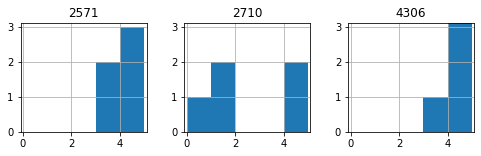

In [7]:
# create histograms for movie ratings
hist = utility_matrix.T.hist(bins=[0,1,2,3,4,5], layout=(1,5), figsize=(14,2));

# set axes
for ax in hist[0]:
    ax.set_ylim(0, 3.1)
    ax.set_xlim(-0.1, 5.1)

### Vraag 3 

Gegeven de bovenstaande histograms wat is de _naam_ van de film met de gemiddelde hoogste rating? 
En wat is de _naam_ van de film waarover de meningen het meest verdeeld zijn?

Naam van de film met gemiddelde hoogste waardering is The Matrix. En de film met de meest verdeelde meningen is The Blair Witch Project.

De histogrammen geven nog niet zo heel veel informatie over de films. Door scatterplots te gebruiken kunnen we de data inzichtelijker maken.

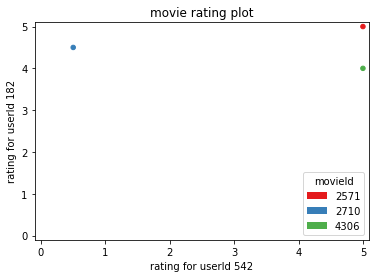

In [8]:
def plot_scatter(matrix, feature1, feature2, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101']):
    # setup plot
    elements = matrix.shape[0]
    scatter = matrix.plot.scatter(feature1, feature2, color = colors[:elements])
    scatter.set_title('movie rating plot')
    
    # plot settings
    scatter.set_xlim(-0.1, 5.1)
    scatter.set_ylim(-0.1, 5.1)
    scatter.set_xlabel('rating for userId {}'.format(feature1))
    scatter.set_ylabel('rating for userId {}'.format(feature2))
    scatter.legend([mpatches.Circle((0,0), 1, fc=c) for c in colors], matrix.index, loc = 'lower right', title = 'movieId')
    
# scatter plot    
plot_scatter(utility_matrix, 542, 182)

In de bovenstaande plot staan de punten voor de drie films. De x-as geeft de rating van Ada (195) en de y-as geeft de rating Carl (376). We kunnen ons dus de films als punten in een abstracte ruimte voorstellen. Zo'n ruimte wordt een **feature space** genoemt.

### Vraag 4

Als je naar deze ruimte kijkt, welke films denk je dan dat het meest op elkaar lijken? Waarom?

Shrek en The Matrix lijken het meest op elkaar gebaseerd op de bovenstaande scatterplot. Dit is omdat ze van beide gebruikers een hoge rating krijgen.

### Vraag 5

Plot de feature space zoals boven, maar dan voor Isaac en Gotlob.

Tip: Als je even snel wil kijken welke userId overeenkomt met welke naam kan je het commando `display(users)` gebruiken.

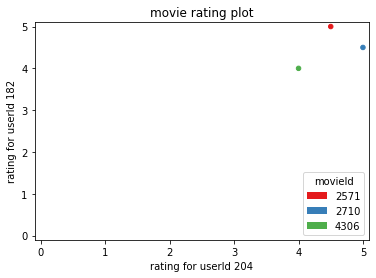

In [9]:
# Isaac - 204
# Gotlob - 182
plot_scatter(utility_matrix, 204, 182)


### Vraag 6

Als je naar _deze_ ruimte kijkt, welke films denk je _dan_ dat het meest op elkaar lijken?

The Matrix en The Blair Witch Project. De ratings daarvan voor beide gebruikers liggen het dichste bij elkaar.

Door de ratings voor te stellen als een ruimte (een feature space) kan je kijken of twee films fysiek dicht bij elkaar zitten. En dat kan wat zeggen over of de films wellicht op elkaar lijken. Met andere woorden, als veel gebruikers die The Matrix goed vonden ook een positieve beoordeling gegeven aan The Blair Witch Project, dan lijken die films wellicht op elkaar.

Een recommender system kan kiezen om iemand die The Matrix goed vond ook The Blair Witch Project aan te bevelen.

In de bovenstaande voorbeelden gebruikten we steeds een 2D-ruimte, een gebruiker per as. Zoals je zag kan de uitkomst flink verschillen per ruimte. Normaal gesproken gebruik je geen 2D-feature space, maar is het aantal dimensies gelijk aan het aantal features in de tabel. In ons voorbeeld zijn dat vijf dimensies (namelijk de ranking van de vijf gebruikers, Ada, Nicolai, Isaac, Gotlob en Carl). 

Helaas is een hoog-dimensionale feature space lastig te plotten. Met een beetje moeite kan je nog 3 dimensies plotten:

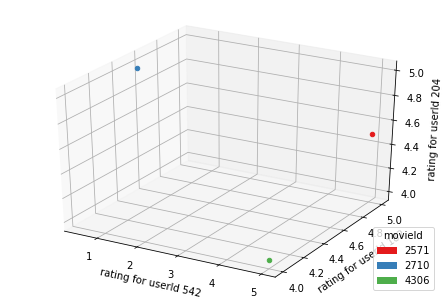

In [10]:
def plot3d(matrix, feature1, feature2, feature3, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101']):  
    # setup 3d plot
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # enter data
    for i, ind in enumerate(matrix.index):
        scatter = ax.scatter(matrix.loc[ind, feature1], matrix.loc[ind, feature2], matrix.loc[ind, feature3], c = colors[i])

    # plot settings
    ax.legend([mpatches.Circle((0,0), 1, fc=c) for c in colors], matrix.index, loc = 'lower right', title = 'movieId')
    ax.set_xlabel('rating for userId {}'.format(feature1))
    ax.set_ylabel('rating for userId {}'.format(feature2))
    ax.set_zlabel('rating for userId {}'.format(feature3))
    
    plt.show()

plot3d(utility_matrix, 542, 182, 204)

Helaas is zo'n 3D-plot lastig te lezen. Welke films liggen er nou dichter bij elkaar in de bovenstaande plot? Bovendien, we hebben nog meer dimensies die we willen laten zien. Een gebruikelijke manier om zo'n hoger dimensionale ruimte te plotten is een _scatter plot matrix_. Hierin maken we alle scatterplots van alle combinaties van dimensies. Dit werkt al een stuk beter:

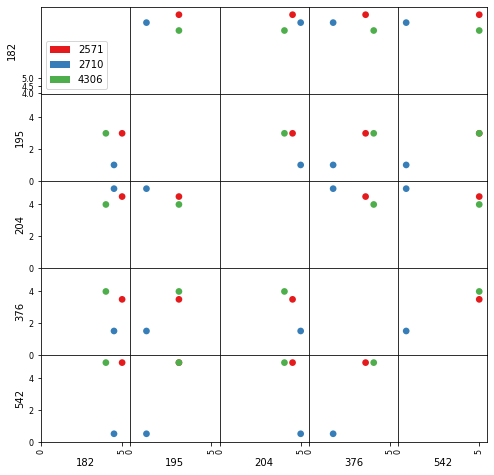

In [11]:
def plot_scatter_matrix(matrix, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101', '#000000', '#999999'], figsize = (8,8)):
    # setup plot
    max_val = matrix.max(axis = 1).max()
    min_val = matrix.min(axis = 1).min()
    fmatrix = matrix.fillna(min_val - 1)
    elements = fmatrix.shape[0]
    axarr = pd.plotting.scatter_matrix(fmatrix, s = 180.0, c = colors[:elements], figsize=figsize, alpha = 1.0, diagonal = '')
    m = fmatrix.shape[1]
    max_val = matrix.max(axis = 1).max()
    min_val = matrix.min(axis = 1).min()
    
    # set axes for all subplots
    for i in range(m):
        for j in range(m):
            axarr[i,j].set_xlim(min_val - 0.5, max_val + 0.5)
            axarr[i,j].set_ylim(min_val - 0.5, max_val + 0.5)

    # set labels for subplots
    labels = fmatrix.index 
    axarr[0,0].legend([mpatches.Circle((0,0),1,fc=c) for c in colors], labels, loc = 'lower left');

plot_scatter_matrix(utility_matrix)

### Vraag 7

a) Als je naar de bovenstaande scatterplot matrix kijkt, welke twee films denk je dat het meest op elkaar lijken? Beargumenteer.

b) Waarom zijn er geen plots getekend op de diagonaal?

a) 2571(The Maxtrix) & 4306 (Shrek), dit is omdat in de meeste scatter plots ze het dichtste bij elkaar staan qua ratings. Daardoor lijkt het erop dat de gemiddelde afstand tussen die 2 films het kleinst is, en daarme het meest op elkaar zouden moeten lijken.
b) Omdat de gebruikers dan tegen over zichzelf zouden worden geplot, wat niet zo nuttig is.

### Similarity

In het vorige deel hebben we gekeken of we aan de hand van de plots van de data konden zien welke films het meest op elkaar lijken. Nu gaan we kijken of we die intuïties iets verder kunnen formaliseren. 

Uiteindelijk willen we een functie maken die, aan de hand van de gegeven data, kan uitrekenen in welke mate twee films op elkaar lijken.

Eerst moeten we een goede definitie van afstand hebben. De eenvoudigste manier is door te kijken naar de verschillen in de ratings van de gebruikers.

<table><thead><tr style="text-align: center;"><th></th><th>2571</th><th></th><th>4306</th><th></th><th>difference</th><th></th></tr></thead>
<tbody><tr><th>182</th><td>5.0</td><td>-</td><td>4.0</td><td>=</td><td>1.0</td><td>(Gotlob vindt The Matrix beter dan Shrek)</td></tr>
<tr><th>195</th><td>3.0</td><td>-</td><td>3.0</td><td>=</td><td>0.0</td><td>(Ada vindt beide films even goed)</td></tr>
<tr><th>204</th><td>4.5</td><td>-</td><td>4.0</td><td>=</td><td>0.5</td><td>(Isaac vindt The Matrix een klein beetje beter)</td></tr>
<tr><th>376</th><td>3.5</td><td>-</td><td>4.0</td><td>=</td><td>-0.5</td><td>(Carl vindt Shrek een klein beetje beter)</td></tr>
<tr><th>542</th><td>5.0</td><td>-</td><td>5.0</td><td>=</td><td>0.0</td><td>(Nicolai vindt beide films even goed)</td></tr>
</tbody></table>

Vervolgens berekenen we de afstand tussen de twee films door de som van de absolute waarde van deze verschillen te nemen:

$$
d = abs(1.0) + abs(0.0) + abs(0.5) + abs(-0.5) + abs(0.0) = 2.0
$$

Deze afstandsmaat noemen we de **manhattan distance** (kijk [hier](https://en.wikipedia.org/wiki/Taxicab_geometry) als je wil weten waarom dit zo heet). Let wel, dit is een afstandsmaat: de waarde wordt _groter_ naarmate de films _minder_ op elkaar lijken. In de praktijk willen we een gelijkheidsmaat: een waarde die groter wordt naarmate de films _meer_ op elkaar lijken. Een afstandsmaat is vrij eenvoudig om te zetten naar een gelijkheidsmaat. Er zijn meerdere manieren waarop dit kan, maar een veelgebruikte functie is:

$$
s = 1/(1 + d)
$$

Waarbij $s$ staat voor _similarity_ en $d$ voor de _distance_. In het geval van dit voorbeeld is de similarity dus:

$$
1 / (1 + 2.0) = 0.33
$$

Voor de volledigheid geven we ook de formele definitie van de manhattan distance. Gegeven item (film) $x$ en item $y$ met $n$ features (user ratings) definiëren we de manhattan distance $d(x, y)$ als volgt:

$$
d(x, y) = \Sigma_{i=1}^{n}|x_{i} - y_{i}|
$$ 

$$
s(x, y) = 1/(1 + d(x, y))
$$


Hier volgt de implementatie van de manhattan distance:

In [12]:
def manhattan_distance(matrix, id1, id2):
    """Compute manhattan distance between two rows."""    
    # only take the features that have values for both id1 and id2
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]
    
    # compute the distances for the features
    distances = features1 - features2
    
    # return the absolute sum
    return distances.abs().sum()

def manhattan_similarity(matrix, id1, id2):
    """Compute manhattan similarity between two rows."""
    # compute distance
    distance = manhattan_distance(matrix, id1, id2)
    
    # if no distance could be computed (no shared features) return a similarity of 0
    if distance is np.nan:
        return np.nan
    
    # else return similarity
    return 1 / (1 + distance)

similarity = manhattan_similarity(utility_matrix, 2571, 4306)
print(f'Similarity between The Matrix and Shrek: {similarity:.2f}')

Similarity between The Matrix and Shrek: 0.33


Net als we eerder de utility matrix hadden gemaakt om gemakkelijk ratings op te kunnen zoeken, zo gaan we nu een matrix maken om makkelijk te kunnen zoeken naar similarity:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>2571</th><th>2710</th><th>4306</th></tr></thead><tbody><tr><th>2571</th><td>1.000000</td><td>0.095238</td><td>0.333333</td></tr><tr><th>2710</th><td>0.095238</td><td>1.000000</td><td>0.086957</td></tr><tr><th>4306</th><td>0.333333</td><td>0.086957</td><td>1.000000</td></tr></tbody></table>

### Vraag 8

De functie `create_similarity_matrix_manhattan()` hieronder is nog niet af. Er wordt al een matrix met de juiste dimensies gegenereerd, maar de rest is aan jou. Vul de matrix met de juiste similarities:

In [13]:
def create_similarity_matrix_manhattan(matrix):
    """Creates the similarity matrix based on manhattan distance."""
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    # Iter of rows & columns, cause I couldnt get apply/-map to work
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index,i] = manhattan_similarity(matrix,float(index),float(i))
    
    return similarity_matrix

similarity_matrix = create_similarity_matrix_manhattan(utility_matrix)
display(similarity_matrix)

movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.095238,0.333333
2710,0.095238,1.000000,0.086957
4306,0.333333,0.086957,1.000000


### Check

In [14]:
answers.test_8(create_similarity_matrix_manhattan, utility_matrix)

Check output type: success!
Testing create_similarity_matrix_manhattan on complete data set: success!
Testing create_similarity_matrix_manhattan on incomplete data set: success!
          2571      2710  4306
2571  1.000000  0.153846   NaN
2710  0.153846  1.000000   NaN
4306       NaN       NaN   1.0


### Vraag 9

a) In de bovenstaande matrix bevatten alle cellen op de diagonaal de waarde 1.0. Waarom is dat?

b) De output van de tweede test is een matrix die een aantal NaN's bevat. Waar zou dit door kunnen komen?

a) Omdat de afstand tot zichzelf wordt berekend, en die is natuurlijk 0, waardoor de similarity 1 wordt.
b) Omdat sommige gebruikers die films geen rating hebben gegeven, waardoor de ratings NaN zijn, en daar wordt ook mee verder gerekend, wat betekent dat het eind resultaat ook NaN's zijn.

### Euclidean similarity

Manhattan distance is een makkelijke maat om te gebruiken, maar wordt in de praktijk weinig gebruikt. Want stel, je hebt twee films met soortgelijke ratings, maar telkens met een klein verschil. Dan tel je bij de Manhattan distance alle verschillen in elke dimensie, hoe klein ze ook zijn, bij elkaar op. Daardoor lijkt het alsof de films toch veel verschillen.

Een populairdere maat is daarom de **Euclidische afstand**. Dit is de afstand die je krijgt als je de feature-space als een gewone fysieke ruimte beschouwd en de stelling van Pythagoras gebruikt om de afstand tussen twee punten (films) te bepalen. Door het gebruik van machten in de berekening van deze afstand worden kleine verschillen vrijwel genegeerd.

Net als bij de Manhattan distance kijken we eerst naar de verschillen in afstand.

<table><thead><tr style="text-align: center;"><th></th><th>2571</th><th></th><th>4306</th><th></th><th>difference</th><th></th></tr></thead>
<tbody><tr><th>182</th><td>5.0</td><td>-</td><td>4.0</td><td>=</td><td>1.0</td><td>(Gotlob vindt The Matrix beter dan Shrek)</td></tr>
<tr><th>195</th><td>3.0</td><td>-</td><td>3.0</td><td>=</td><td>0.0</td><td>(Ada vindt beide films even goed)</td></tr>
<tr><th>204</th><td>4.5</td><td>-</td><td>4.0</td><td>=</td><td>0.5</td><td>(Isaac vindt The Matrix een klein beetje beter)</td></tr>
<tr><th>376</th><td>3.5</td><td>-</td><td>4.0</td><td>=</td><td>-0.5</td><td>(Carl vindt Shrek een klein beetje beter)</td></tr>
<tr><th>542</th><td>5.0</td><td>-</td><td>5.0</td><td>=</td><td>0.0</td><td>(Nicolai vindt beide films even goed)</td></tr>
</tbody></table>

Vervolgens gebruiken we de stelling van Pythagoras voor het bereken van de euclidische afstand. In een 2D-ruimte is de stelling $d^2 = x^2 + y^2$ of, herschreven: $d = \sqrt{x^2 + y^2}$. In het 3D-geval is $d = \sqrt{x^2 + y^2 + z^2}$. In het algemeen is de stelling voor $n$ features $f_{1}$ t/m $f_{n}$:

$$
d = \sqrt{f_{1}^2 + f_{2}^2 + \ldots + f_{n}^2}
$$

In ons voorbeeld is de afstand $d$ dus:

$$
d = \sqrt{1.0^2 + 0.0^2 + 0.5^2 + -0.5^2 + 0.0^2} \approx 1.22
$$

Als we deze afstand omrekenen naar similarities:

$$
1 / (1 + 1.22) \approx 0.45
$$

De formele definitie:

$$
d(x, y) = \sqrt{\Sigma_{i=1}^{n}(x_{i} - y_{i})^2}
$$

$$
s(x, y) = 1/(1 + d(x, y))
$$

### Vraag 10

Implementeer hieronder de functie `create_similarity_matrix_euclid()`:

In [15]:
# implement some helper functions?
# TODO
def euclid_dist(matrix, id1, id2):
    # only take the features that have values for both id1 and id2
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]
    
    distance = np.sqrt(sum((features1-features2)**2))
    
    return distance
    

def euclid_sim(matrix, id1, id2):
    # compute distance
    distance = euclid_dist(matrix, id1, id2)
    
    # if no distance could be computed (no shared features) return a similarity of 0
    if distance is np.nan:
        return np.nan
    
    # else return similarity
    return 1 / (1 + distance)   

def create_similarity_matrix_euclid(matrix):
    """creates the similarity matrix based on eucledian distance"""
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    # Iter of rows & columns, cause I couldnt get apply/-map to work
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index,i] = euclid_sim(matrix,float(index),float(i))
    
    return similarity_matrix
    

similarity = create_similarity_matrix_euclid(utility_matrix)
display(similarity)

movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.157186,0.449490
2710,0.157186,1.000000,0.150722
4306,0.449490,0.150722,1.000000


### Check

In [16]:
answers.test_10(create_similarity_matrix_euclid, utility_matrix)

Check output type: success!
Testing create_similarity_matrix_euclid on complete data set: success!
Testing create_similarity_matrix_euclid on incomplete data set: success!


### Cosine similarity

Voor het vergelijken van verschillende items wordt in de praktijk veel van de _cosine similarity_ gebruik gemaakt. Voor het bepalen hiervan trekken we twee denkbeeldige lijnen van de oorsprong naar de data punten die we willen vergelijken en nemen we de hoek tussen die twee lijnen: 

<img src = './include/cosine similarity.png'>

In het bovenstaande voorbeeld bepalen we de cosine similarity voor film 2571 en 2710 en kijken we even alleen naar de ratings van gebruiker 195 en 542. De hoek tussen de twee lijnen voor beide films $\Theta$ is $0.57^{\circ}$ rad. De cosine similarity is gedefinieerd als de cosinus van deze hoek. In dit voorbeeld is de similarity dus cos$(0.57) \approx 0.84$.

In het geval van de cosine similarity doet de afstand van een punt tot oorsprong er niet toe. Waarom zou dit een voordeel kunnen zijn?

Het bereken van de cosine similarity is eenvoudiger dan het voorbeeld doet vermoeden voor twee punten $A = (a_1, a_2)$ en $B = (b_1, b_2)$ is de cosine similarity:
$$
\textrm{cos}(A, B) = \frac{a_1*b_1 + a_2*b_2}{\sqrt{a_1^2 + a_2^2}*\sqrt{b_1^2 + b_2^2}}
$$

In ons geval is dat dus:
$$
\textrm{cos}(2571, 2710) = \frac{3.0*1.0 + 5.0*0.5}{\sqrt{3.0^2 + 5.0^2} * \sqrt{1.0^2 + 0.5^2}} \approx 0.84
$$

In de bovenstaande berekening hebben we voor het gemak aangenomen dat er maar twee features zijn (de ratings van gebruiker 195 en 542). In werkelijkheid hebben we natuurlijk niet twee features, maar veel meer. In ons geval hebben we er vijf. De algemene formule voor de cosinus van items met $n$ features $A = (a_1, a_2, \ldots, a_n)$ en $B = (b_1, b_2, \ldots, b_n)$ is:

$$
\textrm{cos}(A, B) = \frac{a_1*b_1 + a_2*b_2 + \ldots + a_n*b_n}{\sqrt{a_1^2 + a_2^2 + \ldots + a_n^2}*\sqrt{b_1^2 + b_2^2 + \ldots b_n^2}}
$$

In ons geval is dat dus:
$$
\textrm{cos}(2571, 2710) = \frac{5.0*4.5  + 3.0*1.0 + 4.5*5.0 + 3.5*1.5 + 5.0*0.5}{\sqrt{5.0^2 + 3.0^2 + 4.5^2 + 3.5^2 + 5.0^2} * \sqrt{4.5 ^ 2  + 1.0^2 + 5.0^2 + 1.5^2 + 0.5^2}} \approx 0.83
$$

De formele defnitie:
$$
\textrm{cos}(A, B) = \frac{\sum_{i = 1}^n a_i * b_i}{\sqrt{\sum_{i = 1}^n a_i^2}{\sqrt{\sum_{i = 1}^n b_i^2}}}
$$

### Vraag 11

Gebruik de bovenstaande formule voor het implementeren van de functie `create_similarity_matrix_cosine()` hieronder. Let erop dat als er geen overeenkomende features zijn, je `0.0` returned. Er is een randgeval bij een film die enkel wordt gerate met `0.0`, `return` ook dan `0.0`. Waarom is dit eigenlijk een randgeval bij het berekenen van cosine similarity?

In [17]:
# TODO
def cos_sim(matrix, id1, id2):
    # only take the features that have values for both id1 and id2
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]

    #if sum(features1)==0. or sum(features2)==0.:
        #return 1.
    
    if id1 == id2:
        return 1.
    
    sim = (np.sqrt(sum(features1**2))*np.sqrt(sum(features2**2)))
    
    if sim == 0.:
        return np.nan
    
    return sum(features1*features2)/sim

def create_similarity_matrix_cosine(matrix):
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    # Iter of rows & columns, cause I couldnt get apply/-map to work
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index,i] = cos_sim(matrix,float(index),float(i))
    
    return similarity_matrix

similarity = create_similarity_matrix_cosine(utility_matrix)
display(similarity)

movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.834732,0.992844
2710,0.834732,1.000000,0.782908
4306,0.992844,0.782908,1.000000


### Check

In [18]:
answers.test_11(create_similarity_matrix_cosine, utility_matrix)

Check output type: success!
Testing create_similarity_matrix_cosine on complete data set: success!
Testing create_similarity_matrix_cosine on incomplete data set: success!
Testing create_similarity_matrix_cosine on a dataset with a movie that has only been rated with 0: success!


### Mean centering

Het probleem met de cosine similarity is dat het erg gevoelig is voor bias. Dat wil zeggen, als de gemiddelde waarde van een feature geen 0 is, dan geeft de cosine similarity geen goede scores. In ons geval is dit een probleem. De gemiddelde rating per gebruiker is zeker geen 0.

De oplossing hiervoor is **mean centering**. Hierbij is het idee om de gemiddelde rating van een gebruiker te verminderen met het gemiddelde _van diezelfde_ gebruiker. Aangezien we in de utility matrix elke kolom de ratings van één gebruiker staan komt het er dus op neer elke kolom te verminderen met het gemiddelde van die kolom.

Hieronder zie je het effect hiervan. In Figuur 1 zien we de cosine similarity zonder mean centering, in Figuur 2 de cosine similairty van dezelfde twee punten, maar met centering. De cosine similarity toegepast op een mean centered utility matrix wordt ook wel de **adjusted cosine** genoemd. 

<table>
    <tr style ="background-color: #ffffff"><td style="text-align:center">Figuur 1</td><td style="text-align:center">Figuur 2</td></tr>
    <tr><td><img src = './include/cosine similarity.png'></td><td><img src = './include/adjusted cosine similarity.png'></td></tr>
</table>

### Vraag 12

Implementeer hieronder de functie `mean_center_columns()`:

In [19]:
def mean_center_columns(matrix):
    mean_centered = matrix.copy()
    for col in list(matrix.columns):
        mean_centered[col] -= matrix[col].mean()
        
    return mean_centered


centered_utility_matrix = mean_center_columns(utility_matrix)
display(centered_utility_matrix)

similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

userId,182,195,204,376,542
movieId,,,,,
2571,0.5,0.666667,0.0,0.5,1.5
2710,0.0,-1.333333,0.5,-1.5,-3.0
4306,-0.5,0.666667,-0.5,1.0,1.5


movieId,2571,2710,4306
movieId,,,
2571,1.000000,-0.942604,0.804393
2710,-0.942604,1.000000,-0.956601
4306,0.804393,-0.956601,1.000000


### Check

In [20]:
answers.test_12(mean_center_columns, utility_matrix, create_similarity_matrix_cosine)

Check output type: success!
Testing mean_center_columns on complete data set: success!
Testing create_similarity_matrix_cosine on complete data set: success!
Testing mean_center_columns on incomplete data set: success!
Testing create_similarity_matrix_cosine on incomplete data set: success!


### Voorspellingen

We hebben nu meerdere maten voor het vergelijken van films. Hoe kunnen we de similarity functies gebruiken voor het aanbevelen van films. Dit probleem kunnen we herformuleren: Gegeven een gebruiker (de *target user*) die een bepaalde film (de *target film*) nog niet heeft gezien, hoe zou deze gebruiker de film raten na het zien?

De kern van het probleem is dus het voorspellen van een "missende" rating.

Er zijn veel mogelijke aanpakken, maar een veelgebruikte manier voor het aanbevelen van items is **neighborhood based**. De intuïtie is weer eenvoudig. Voor de *target film*, kijk welke films erop lijken (de *neighborhood*) en kijk wat de *target user* daarvon vond. 

Het algoritme bestaat uit twee stappen:

1. Selecteer de *neighborhood* van de *target film*. Selecteer alle films waarvoor geldt dat:
    - de *target user* de film gezien heeft
    - de film zeer vergelijkbaar is met de *target film*
    
    
2. Neem het gewogen gemiddelde van de geselecteerde films. Dat wil zeggen dat een film die meer vergelijkbaar is met de *target film* ook meer bijdraagt aan het gemiddelde.

Om deze stappen uit te werken hebben we iets meer data nodig. Voor het uitproberen van het algoritme voegen we handmatig wat data toe. We introduceren 2 extra gebruikers (123 en 456) en een extra film (4444):

In [21]:
# create some mock data
l = [[123, 2571, 5.0, 0], [123, 2710, 1.5, 0], [123, 4444, 4.0, 0],
     [456, 2571, 1.5, 0], [456, 2710, 5.0, 0], [456, 4444, 1.0, 0],
     [182, 4444, 3.0, 0], [195, 4444, 2.0, 0], [204, 4444, 4.0, 0],
     [376, 4444, 4.5, 0], [542, 4444, 4.5, 0], [123, 5555, 3.5, 0], 
     [456, 5555, 3.5, 0]]
extra_data = pd.DataFrame(l, columns = ratings.columns)
more_ratings = pd.concat([ratings, extra_data])

# recompute utility matrix
utility_matrix2 = pivot_ratings(more_ratings)
display(utility_matrix2)

# recompute similarity matrix
centered_matrix = mean_center_columns(utility_matrix2)
similarity = create_similarity_matrix_cosine(centered_matrix)
display(similarity)

userId,123,182,195,204,376,456,542
movieId,,,,,,,
2571,5.0,5.0,3.0,4.5,3.5,1.5,5.0
2710,1.5,4.5,1.0,5.0,1.5,5.0,0.5
4306,NaN,4.0,3.0,4.0,4.0,NaN,5.0
4444,4.0,3.0,2.0,4.0,4.5,1.0,4.5
5555,3.5,NaN,NaN,NaN,NaN,3.5,NaN


movieId,2571,2710,4306,4444,5555
movieId,,,,,
2571,1.000000,-0.816248,0.732576,0.419222,-0.640184
2710,-0.816248,1.000000,-0.981707,-0.761017,0.747409
4306,0.732576,-0.981707,1.000000,0.584364,NaN
4444,0.419222,-0.761017,0.584364,1.000000,-0.961524
5555,-0.640184,0.747409,NaN,-0.961524,1.000000


Zoals je ziet hebben de nieuwe gebruikers (123 en 456) geen rating voor de film Shrek (4306). Die ratings gaan we proberen te voorspellen.

Om een beeld te krijgen van deze nieuwe data maken we weer een plot:

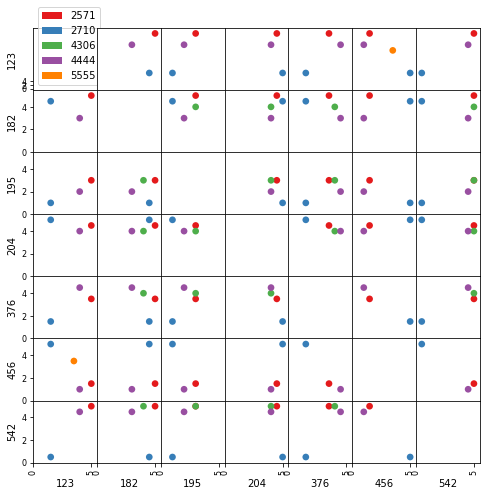

In [22]:
plot_scatter_matrix(utility_matrix2)

### Vraag 13

Als je naar de bovenstaande plots kijkt, welke film zou je aanbevelen aan gebruiker 123? En aan gebruiker 456? Beargumenteer.

Voor gebruiker 123 zou ik film 4306 aanraden. Die film ligt vrij vaak bij de films 2571 en 4444, en dat zijn 2 films die 123 een hoge rating gaf.

Voor gebruiker 456 zou ik ook film 4306 aanraden. De andere film die gebruiker niet gezien heeft is 5555, maar er zijn voor mij te weinig data punten om goed te bepalen wat de gebruiker van die film zou vinden. Verder staat 4306 met enige regelmaat in de buurt van film 2710, en film 2710 is een film die gebruiker 456 een hoge rating gaf. Daarnaast is het voor de keren 5555 voorkomt met 2710, is de afstand niet echt dichtbij, maar ook niet heel erg ver. Dat maakt het schatten extra lastig.

### Vraag 14

We gaan eerst Stap 1 van het algoritme uitwerken:

1. Selecteer de neighborhood van de target film. Selecteer alle films waarvoor geldt dat:
    - de target user de film gezien heeft
    - de film zeer vergelijkbaar is met de target film

We moeten alleen een definitie geven van "zeer vergelijkbaar". Hiervoor kunnen we vele keuzes maken. Vaak worden de top $k$ meest vergelijkbare items genomen. Waarbij de beste waarde voor $k$ proefondervindelijk wordt vastgesteld. Bovendien is het belangrijk om alleen items te nemen waarvan de _cosine similarity_ groter is dan 0.

Implementeer hieronder de functie `select_neighborhood()`. Deze functie krijgt als input een `Series` met de similarities, een `Series` met ratings en de parameter `k` en geeft een `Series` terug met de top `k` `movieId`'s en de bijbehorende similarities. Voor bijvoorbeeld gebruiker 123, film 4306 en k = 10 geeft de functie de volgende `Series` terug:

    2571    0.732576
    4444    0.584364
    Name: 4306, dtype: float64
    
Let op: deze output bevat noch de film 2710 noch de film 4306. De film 2710 mist omdat de similarity kleiner is dan 0, en 4306 mist omdat gebruiker 123 deze nog niet heeft gezien. De output bevat bovendien maar 2 items, in plaats van 10. Dit komt omdat er in totaal maar 2 films zijn die een similarity groter dan 0 hebben met film 4306.

In [23]:
def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    # drop all non watched movies
    
    for key,v in ratings.iteritems():
        if np.isnan(v):
            similarities = similarities.drop(labels=key)
    
    for key,v in similarities.iteritems():
        if not v > 0.:
            similarities = similarities.drop(labels=key)
            
    similarities = similarities.sort_values(ascending=False)
    
    return similarities[:k]
    
neighborhood = select_neighborhood(similarity[4306], utility_matrix2[123], 10)
display(neighborhood)

movieId
2571    0.732576
4444    0.584364
Name: 4306, dtype: float64

### Check

In [24]:
answers.test_14(select_neighborhood, similarity, utility_matrix2)

Check output type: success!
Check select_neighborhood for user 123: success!
Check select_neighborhood for user 456: success!
Check select_neighborhood for movie 2710 and user 195: success!
Check empty neighborhood: success!
Check only zero similarity: success!


### Vraag 15

Nu rest nog stap 2 van het algoritme:

2. Neem het gewogen gemiddelde van de geselecteerde films. Dat wil zeggen dat een film die meer vergelijkbaar is met de _target film_ ook meer bijdraagt aan het gemiddelde.

In het voorbeeld hierboven bevat de neighborhood de similarities $0.73$ en $0.58$ voor respectievelijk de films 2571 en 4444. De ratings die gebruiker 123 voor deze films heeft gegeven zijn $5.0$ en $4.0$. Het gewogen gemiddelde is dan:
$$
\textrm{predicted rating} = \frac{5.0 * 0.73+4.0 * 0.58}{0.73 + 0.58} \approx 4.56
$$

De formele definitie (met $r_i$ de rating en $s_i$ de similarity voor film $i$):
$$
\textrm{predicted rating} = \frac{\sum_{\textrm{i in neighborhood}} r_i * s_i}{\sum_{\textrm{i in neighborhood}}s_i}
$$

Implementeer hieronder de laatste stap van het item based collaborative filtering algoritme. Implementeer de functie `weighted_mean()`.

In [25]:
def weighted_mean(neighborhood, ratings):  
    pred_rating = 0.
    for k,v in neighborhood.iteritems():
        pred_rating += v*ratings[k]
    
    if sum(neighborhood)==0:
        return np.nan
    return pred_rating/sum(neighborhood)
    
    
neighborhood1 = select_neighborhood(similarity[4306], utility_matrix2[123], 10)
neighborhood2 = select_neighborhood(similarity[4306], utility_matrix2[456], 10)
prediction1 = weighted_mean(neighborhood1, utility_matrix2[123])
prediction2 = weighted_mean(neighborhood2, utility_matrix2[456])
# prediction2 = predict_rating_item_based(adjusted_cosine_similarity_matrix, eva, 4306)
print(f'User 123 predicted rating for Shrek {prediction1:.2f}')
print(f'User 456 predicted rating for Shrek {prediction2:.2f}')  

User 123 predicted rating for Shrek 4.56
User 456 predicted rating for Shrek 1.28


### Check

In [26]:
answers.test_15(select_neighborhood, similarity, utility_matrix2, weighted_mean)

Check output type: success!
Testing predictions: success!
Testing prediction for empty neighborhood: success!


### Vraag 16

Conclusie: Zou je gebruiker 123 Shrek aanraden? En gebruiker 456?

Ik zou gebruiker 123 Shrek aanraden vanwege de hoge predicted rating van 4.56. En ik zou gebruiker 456 de film shrek niet aanraden vanwege de lage predicted rating van 1.28.

# Deel 2: User based filtering

Tot nu toe keken we naar item based filtering. Hier voorspellen we ratings aan de hand van vergelijkbaarheid van de items (films). De voornaamste tegenhanger van item based filtering is *user based filtering*. Dit is het collaborative filtering equivalent van iemand met dezelfde filmsmaak om advies vragen. 

Het proces van user based filtering is vrijwel identiek aan item based filtering. We draaien alleen de rollen om:

- in plaats van een utility matrix met horizontaal de gebruikers en verticaal de films, wisselen we de assen om  
- in plaats van een similarity matrix voor films maken we een similarity matrix voor gebruikers
- in plaats van een neighborhood van de _target film_ selecteren we een neighborhood van de _target user_.
- in plaats van een gewogen gemiddelde van de ratings van vergelijkbare films nemen we een gewogen gemiddelde van de ratings van vergelijkbare users.

Voor de onderstaande vragen gaan we weer van de _uitgebreide ratings data_ uit.

Tip: Voor de onderstaande vragen hoef je maar weinig code te schrijven. **Maak zoveel mogelijk gebruik van de functies die je hierboven geschreven hebt.** Als je in een cel meer dan een paar regels code moet schrijven maak je het waarschijnlijk te ingewikkeld.

In [27]:
display(more_ratings)

,userId,movieId,rating,timestamp
0,182,2571,5.0,1054779786
1,182,2710,4.5,1063284735
2,182,4306,4.0,1054780155
3,195,2571,3.0,974705726
4,195,2710,1.0,974706758
5,195,4306,3.0,994032742
6,204,2571,4.5,1327183462
7,204,2710,5.0,1327185697
8,204,4306,4.0,1327182567
9,376,2571,3.5,1364994024


### Vraag 17

Maak een nieuwe utility matrix, maar nu met de gebruikers als rijen en de films als kolommen.

Tip: met `df.T` kan je de rijen en kolommen van dataframe `df` omwisselen.

In [28]:
# make sure that utility_matrix contains the new flipped utility matrix

utility_matrix3 = more_ratings.pivot(index='userId',columns='movieId',values='rating')


display(utility_matrix3)

movieId,2571,2710,4306,4444,5555
userId,,,,,
123,5.0,1.5,NaN,4.0,3.5
182,5.0,4.5,4.0,3.0,NaN
195,3.0,1.0,3.0,2.0,NaN
204,4.5,5.0,4.0,4.0,NaN
376,3.5,1.5,4.0,4.5,NaN
456,1.5,5.0,NaN,1.0,3.5
542,5.0,0.5,5.0,4.5,NaN


### Check

In [29]:
answers.test_17(utility_matrix3)

Check output type: success!
Check select_neighborhood for user 123: success!


### Vraag 18

Maak een scatter plot matrix van de utility matrix.

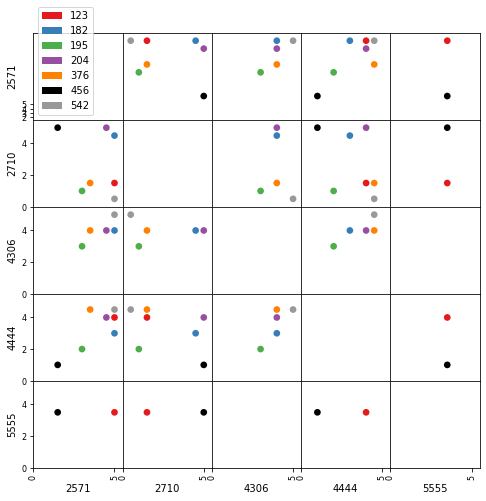

In [30]:
# TODO
plot_scatter_matrix(utility_matrix3)

### Vraag 19

Maak een mean centered utility matrix genaamd `centered_utility_matrix`. Let hierbij op: Dit is het enige waarbij de rollen niet zijn omgedraaid. We willen nog steeds de gemiddelde rating van de _gebruikers_ als offset gebruiken, niet die van de films. Het gaat er namelijk niet om hoe een gebruiker afwijkt van het gemiddelde rating van een film, maar wel hoe de gebruiker afwijkt van zijn gemiddelde rating bij een film. Met ander woorden, je moet hier de rijen centeren in plaats van de kolommen.

In [31]:
# TODO
centered_utility_matrix = mean_center_columns(utility_matrix3.T).T

display(centered_utility_matrix)

movieId,2571,2710,4306,4444,5555
userId,,,,,
123,1.500,-2.000,NaN,0.500,0.00
182,0.875,0.375,-0.125,-1.125,NaN
195,0.750,-1.250,0.750,-0.250,NaN
204,0.125,0.625,-0.375,-0.375,NaN
376,0.125,-1.875,0.625,1.125,NaN
456,-1.250,2.250,NaN,-1.750,0.75
542,1.250,-3.250,1.250,0.750,NaN


### Check

In [32]:
answers.test_19(centered_utility_matrix)

Check output type: success!
Testing mean centered matrix on complete data set: success!


### Vraag 20

Bereken de adjusted cosine similarity matrix voor de gebruikers en sla deze op in een variabele genaamd `similarity`.

In [33]:
similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

userId,123,182,195,204,376,456,542
userId,,,,,,,
123,1.000000,0.000000,0.928191,-0.662994,0.805892,-0.888218,0.963526
182,0.000000,1.000000,0.152894,0.662541,-0.575160,0.374705,-0.201498
195,0.928191,0.152894,1.000000,-0.636364,0.694999,-0.719575,0.918532
204,-0.662994,0.662541,-0.636364,1.000000,-0.959760,0.828190,-0.838659
376,0.805892,-0.575160,0.694999,-0.959760,1.000000,-0.930596,0.915934
456,-0.888218,0.374705,-0.719575,0.828190,-0.930596,1.000000,-0.918912
542,0.963526,-0.201498,0.918532,-0.838659,0.915934,-0.918912,1.000000


### Check

In [34]:
answers.test_20(similarity)

Check output type: success!
Testing similarity of complete data set: success!


### Vraag 21

Bereken de neighborhood voor gebruiker 123 en 456 ten opzichte van film 4306. Sla de neighborhood van gebruiker 123 op in een variabele genaamd `neighborhood1` en voor gebruiker 456 in een variabele genaamd `neighborhood2`.

In [35]:
# TODO
neighborhood1 = select_neighborhood(similarity[123],utility_matrix3[4306],10)
neighborhood2 = select_neighborhood(similarity[456],utility_matrix3[4306],10)

print(neighborhood1) # print the neighborhood for user 123
print(neighborhood2) # print the neighborhood for user 456

userId
542    0.963526
195    0.928191
376    0.805892
Name: 123, dtype: float64
userId
204    0.828190
182    0.374705
Name: 456, dtype: float64


### Check

In [36]:
answers.test_21(neighborhood1, neighborhood2)

Check output type: success!
Check select_neighborhood for user 123: success!
Check select_neighborhood for user 456: success!


### Vraag 22

Bereken het gewogen gemiddelde voor de neighborhoods van user 123 en 456 (met de ratings voor film 4306).

In [37]:
# TODO
prediction1 = weighted_mean(neighborhood1, utility_matrix3[4306])
prediction2 = weighted_mean(neighborhood2, utility_matrix3[4306])

print(f'User 123 predicted rating for Shrek {prediction1:.2f}')
print(f'User 456 predicted rating for Shrek {prediction2:.2f}') 

User 123 predicted rating for Shrek 4.01
User 456 predicted rating for Shrek 4.00


### Check

In [38]:
answers.test_22(prediction1, prediction2)

Check output type: success!
Testing predictions: success!


### Vraag 23

Als je deze user based voorspelling vergelijkt met de item based voorspelling, welke lijkt je dan beter? Beargumenteer in een paar korte zinnen. (In het volgende deel gaan we kijken hoe je de kwaliteit van de aanpak kan evalueren.)   

Geen van beide lijkt mij beter. Dit omdat wij niet kunnen bepalen wat de gebruikers daadwerkelijk vonden van de films. Als we dat wel wisten konden wij wat zeggen over de kwaliteit van de voorspellingen. Maar de daadwerkelijke ratings hebben wij niet, dus we kunnen geen uitspraak er over doen. Geen van beide is dus beter dan de ander.

# Deel 3: Evaluatie

We hebben nu gezien hoe we user ratings kunnen voorspellen. We hebben verschillende aanpakken gezien: _user-based_ en _item-based_. We hebben verschillende _similarity-maten_ gezien: _cosine similarity_ en _euclidean similarity_. Wat hebben we hier nu aan? Welk algoritme werkt het beste?

Wat de beste aanpak is valt geen eenduidig antwoord op te geven. Dit hangt af van de aard van de data. We kunnen dus wel gaan onderzoeken wat het beste werkt voor een specifieke dataset. In dit deel van de opdracht gaan we kijken naar wat het beste werkt voor de MovieLens dataset.

Wat we tot nu toe hebben geschreven is een algoritme om ratings mee te voorspellen. Dit is nog geen volledig recommender system. Dus we kunnen ook nog geen uitspraken doen over het resulterende recommender system. We kunnen echter wel iets zeggen over hoe goed de voorspellingen zijn. Om dat te doen gebruiken we hier weer de MovieLens dataset, maar dit keer gebruiken we een iets grotere subset.

### Offline testen met een test set:

Een veelgebruikte strategie is het opsplitsen van de data in een _training set_ en een _test set_. Op basis van de _training set_ leren we de overeenkomsten, waarmee we vervolgens voorspellingen kunnen doen voor de _test set_. Deze scheiding is belangrijk omdat zo de _test set_ onbekende data blijft, deze hebben we niet meegenomen in het leren van de overeenkomsten. Dus kunnen we testen of de voorspellingen op basis van de overeenkomsten uit de _training set_ ook werken voor nieuwe / onbekende data.

Hiervoor doorlopen we straks de volgende stappen:

* We splitsen de data vervolgens op in twee subsets: een _test set_ en een _training set_.
* Op basis van de _training set_ maken we een similarity matrix.
* Daaruit voorspellen we de ratings voor de film/user combinaties in de _test set_.
* Vervolgens vergelijken we de voorspelde ratings met de echte ratings uit de _test set_.

### Extra helper functies
We beginnen met het laden van een aantal nuttige helper functies.

In [39]:
def number_of_movies(ratings):
    """ determine the number of unique movie id's in the data """
    return len(ratings['movieId'].unique())

def number_of_users(ratings):
    """ determine the number of unique user id's in the data """
    return len(ratings['userId'].unique())

def number_of_ratings(ratings):
    """ count the number of ratings of a dataset """
    return ratings.shape[0]

def rating_density(ratings):
    """ compute the ratings given a data set """
    return number_of_ratings(ratings) / (number_of_movies(ratings) * number_of_users(ratings))

def split_data(data,d = 0.75):
    """ split data in a training and test set 
       `d` is the fraction of data in the training set"""
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

### Laad de data

Hieronder laden we een nieuwe dataset. Deze bevat ruim 3000 ratings. Om te kunnen testen hoe goed ons algoritme werkt splitsen we de data in twee delen: `ratings_t80_training` (de data waarmee we gaan voorspellen) en `ratings_t80_test` (de data waarmee we testen hoe goed de voorspelling is). 

De dataset heeft een dichtheid van ongeveer 80% (vandaar de uitgang `_t80`). Dat wil zeggen dat gemiddeld elke gebruiker 80% van de films van een rating heeft voorzien. Omdat we een deel van de ratings appart houden voor de test set, blijft daar in de training set maar 60% van over. Dat is trouwens heel veel, in de praktijk haal je dat meestal bij lange na niet. Dit is een subselectie van een veel grotere dataset waarvan de dichtheid ver onder de 1% ligt.

In [40]:
# Load the ratings_t80
ratings_t80 = pd.read_csv('./mini-movielens/ratings_t80.csv')
ratings_t80_training, ratings_t80_test = split_data(ratings_t80)

# Show the stats
print('Stats training set:')
print(f'Number of ratings: {number_of_ratings(ratings_t80_training)}')
print(f'Number of users: {number_of_users(ratings_t80_training)}')
print(f'Number of movies: {number_of_movies(ratings_t80_training)}')
print(f'Density: {rating_density(ratings_t80_training)}')

# Display the first 5 rows of the data
display(ratings_t80.head())

Stats training set:
Number of ratings: 3006
Number of users: 25
Number of movies: 200
Density: 0.6012


,userId,movieId,rating,timestamp
0,68,1,2.5,1158531426
1,68,2,2.5,1158532776
2,68,16,3.5,1158533018
3,68,47,4.0,1158531489
4,68,50,3.0,1158531764


### Vraag 24
Maak een utility matrix in een variabele genaamd `utility` en een _adjusted cosine_ similarity matrix in een variabele genaamd `similarity`. Doe beide voor _item based_ filtering. Gebruik hiervoor de functies die je in deel 1 van de opdracht hebt gemaakt.

Dit kan even duren om te berekenen, misschien zelfs een paar minuten. Het is namelijk aanzienlijk meer data dan in het eerste deel van de opdracht! (De data bevat 200 films, dus de similarity matrix bevat 200 x 200 = 40.000 cellen.)

In [41]:
# TODO
utility = pivot_ratings(ratings_t80_training)
centered_util = mean_center_columns(utility)
similarity = create_similarity_matrix_cosine(centered_util)

display(utility.head())
display(similarity.head())

userId,68,105,177,182,232,249,274,288,298,307,...,474,480,483,590,599,600,603,606,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,NaN,NaN,4.0,NaN,4.0,4.0,4.5,2.0,4.0,...,4.0,NaN,NaN,4.0,3.0,2.5,4.0,2.5,NaN,NaN
2,NaN,NaN,3.5,NaN,4.0,4.0,3.5,2.0,0.5,2.5,...,3.0,3.0,4.0,2.5,NaN,4.0,NaN,NaN,2.0,NaN
16,3.5,4.5,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,3.0,NaN,4.0,NaN,4.5,4.5
32,NaN,3.5,NaN,4.0,NaN,5.0,4.0,NaN,4.0,3.5,...,4.0,4.0,5.0,3.0,3.0,NaN,3.0,4.0,NaN,4.5
47,NaN,5.0,4.5,NaN,4.5,5.0,4.0,NaN,4.0,4.0,...,NaN,4.5,3.5,3.0,4.0,4.0,NaN,3.0,4.5,5.0


movieId,1,2,16,32,47,50,104,110,153,223,...,46578,48385,48394,48516,48780,51662,52722,53125,58559,59315
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.074719,0.006048,-0.123256,-0.052228,0.177143,-0.611335,0.078965,-0.368889,0.172374,...,-0.189154,0.358179,-0.258308,0.553921,0.431211,-0.331644,0.269666,-0.304307,-0.021524,0.351863
2,-0.074719,1.000000,-0.229868,-0.297085,-0.434521,-0.570727,0.176152,-0.170048,0.699054,-0.264236,...,-0.068210,0.103298,0.504474,-0.396351,0.563123,-0.172086,0.136263,0.495172,-0.285229,-0.143689
16,0.006048,-0.229868,1.000000,-0.227995,0.547404,0.708517,-0.140028,-0.071521,0.147167,-0.081598,...,-0.030113,0.191778,-0.429182,0.712472,-0.205609,0.671984,0.455058,0.489067,0.255038,-0.264911
32,-0.123256,-0.297085,-0.227995,1.000000,0.276384,0.337146,-0.433426,0.381141,-0.268527,0.731417,...,0.712671,0.047492,0.821246,-0.036044,0.145748,0.407662,-0.755221,-0.282205,0.521183,0.482450
47,-0.052228,-0.434521,0.547404,0.276384,1.000000,0.272674,-0.714514,0.065212,-0.695938,-0.224932,...,0.178282,0.297428,-0.251417,0.716111,0.147248,0.187771,-0.346008,0.142365,0.577807,0.322909


In [42]:
answers.test_24(utility, similarity)

Check utility: success!
Check similarity: success!


### Snel werken
Zoals je merkt kost het even wat rekentijd om een similarity matrix op te bouwen. Dit kunnen we daarom beter 1x doen, even opslaan en vervolgens kunnen we dit weer inladen. Dit gaat makkelijk met `pandas`. Pickle is een dataformaat dat in weinig bytes veel informatie kwijt kan en snel ingeladen kan worden. 

In de code hieronder slaan we de matrices op als een pickle-bestand (`.pkl`), en laden we deze vervolgens weer in om even te laten zien hoe dat werkt.

In [43]:
utility.to_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
similarity.to_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

u = pd.read_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
s = pd.read_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

pd.testing.assert_frame_equal(u, utility)
pd.testing.assert_frame_equal(s, similarity)

### Voorberekende data
In de rest van de opgave maken we gebruik van een aantal verschillende datasets. Om het laden wat te versnellen en om er zeker van te zijn dat iedereen met dezelfde data rekent hebben we vast de data gesplitst en de utility en de (adjusted cosine) similarity matrix uitgerekend. Met de onderstaande code kan je deze data laden.

In [44]:
ratings = pd.read_csv(f'./mini-movielens/ratings_t80.csv')[['userId', 'movieId', 'rating', 'timestamp']]
training_data = pd.read_pickle(f'./mini-movielens/ratings_t80_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_items.pkl')

display(utility_items.head())
display(similarity_items.head())

print(ratings.shape, training_data.shape, test_data.shape, utility_items.shape, similarity_items.shape)

userId,68,105,177,182,232,249,274,288,298,307,...,474,480,483,590,599,600,603,606,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,NaN,NaN,4.0,NaN,4.0,4.0,4.5,2.0,4.0,...,4.0,NaN,NaN,4.0,3.0,2.5,4.0,2.5,NaN,NaN
2,NaN,NaN,3.5,NaN,4.0,4.0,3.5,2.0,0.5,2.5,...,3.0,3.0,4.0,2.5,NaN,4.0,NaN,NaN,2.0,NaN
16,3.5,4.5,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,3.0,NaN,4.0,NaN,4.5,4.5
32,NaN,3.5,NaN,4.0,NaN,5.0,4.0,NaN,4.0,3.5,...,4.0,4.0,5.0,3.0,3.0,NaN,3.0,4.0,NaN,4.5
47,NaN,5.0,4.5,NaN,4.5,5.0,4.0,NaN,4.0,4.0,...,NaN,4.5,3.5,3.0,4.0,4.0,NaN,3.0,4.5,5.0


movieId,1,2,16,32,47,50,104,110,153,223,...,46578,48385,48394,48516,48780,51662,52722,53125,58559,59315
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.074719,0.006048,-0.123256,-0.052228,0.177143,-0.611335,0.078965,-0.368889,0.172374,...,-0.189154,0.358179,-0.258308,0.553921,0.431211,-0.331644,0.269666,-0.304307,-0.021524,0.351863
2,-0.074719,1.000000,-0.229868,-0.297085,-0.434521,-0.570727,0.176152,-0.170048,0.699054,-0.264236,...,-0.068210,0.103298,0.504474,-0.396351,0.563123,-0.172086,0.136263,0.495172,-0.285229,-0.143689
16,0.006048,-0.229868,1.000000,-0.227995,0.547404,0.708517,-0.140028,-0.071521,0.147167,-0.081598,...,-0.030113,0.191778,-0.429182,0.712472,-0.205609,0.671984,0.455058,0.489067,0.255038,-0.264911
32,-0.123256,-0.297085,-0.227995,1.000000,0.276384,0.337146,-0.433426,0.381141,-0.268527,0.731417,...,0.712671,0.047492,0.821246,-0.036044,0.145748,0.407662,-0.755221,-0.282205,0.521183,0.482450
47,-0.052228,-0.434521,0.547404,0.276384,1.000000,0.272674,-0.714514,0.065212,-0.695938,-0.224932,...,0.178282,0.297428,-0.251417,0.716111,0.147248,0.187771,-0.346008,0.142365,0.577807,0.322909


(3999, 4) (3006, 4) (993, 4) (200, 25) (200, 200)


### Vraag 25

Schrijf hieronder een functie die voor elke rating in de _test data_ een rating voorspelt. Gebruik hiervoor dezelfde _item based_ aanpak als in de vorige opdracht. 

De input van de functie is de similarity matrix, de utility matrix en de test data. De output is een copy van de test data met een extra kolom: de voorspelde rating. De bedoeling is dat de output er zo uitziet als hieronder: 

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>userId</th><th>movieId</th><th>rating</th><th>predicted rating</th></tr></thead><tbody><tr><th>1</th><td>68</td><td>2</td><td>2.5</td><td>3.487983</td></tr><tr><th>3</th><td>68</td><td>47</td><td>4.0</td><td>3.457851</td></tr><tr><th>6</th><td>68</td><td>110</td><td>2.5</td><td>3.625071</td></tr><tr><th>14</th><td>68</td><td>344</td><td>2.5</td><td>3.457997</td></tr><tr><th>27</th><td>68</td><td>593</td><td>3.5</td><td>3.494299</td></tr><tr><th  style="text-align: center;" colspan=5>...</th></tr></tbody></table>

In [45]:
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    ratings_test_c['predicted rating'] = 0.
    for index,row in user_item_pairs.iterrows():
        neighborhood = select_neighborhood(similarity[row['movieId']],utility[row['userId']],100)
        ratings_test_c.at[index,'predicted rating'] = weighted_mean(neighborhood,utility[row['userId']])
    return ratings_test_c
    
predicted_item_based = predict_ratings_item_based(similarity_items, utility_items, test_data[['userId', 'movieId', 'rating']])
display(predicted_item_based.head())

,userId,movieId,rating,predicted rating
1,68,2,2.5,3.487983
3,68,47,4.0,3.457851
6,68,110,2.5,3.625071
14,68,344,2.5,3.457997
27,68,593,3.5,3.494299


In [46]:
answers.test_25(predict_ratings_item_based, similarity_items, utility_items, test_data)

Computing solution: success!
Testing layout of prediction: success!
Testing values of prediction: success!


### Mean squared error

Hoe meten we nu hoe goed de voorspelling is? De manier waarop we dit doen lijkt een beetje op bepalen van *similarity* tussen films of gebruikers. We bepalen eerst de afwijking (de *error*) per voorspelde rating:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th>user</th><th>movie</th><th>:</th><th>actual<br>rating</th><th>-</th><th>predicted<br>rating</th><th>=</th><th>difference</th></tr></thead><tbody>
    <tr><td>68</td><td>2</td><td></td><td>2.5</td><td>-</td><td>3.487983</td><td>=</td><td>-0.99</td></tr>
    <tr><td>68</td><td>47</td><td></td><td>4.0</td><td>-</td><td>3.457851</td><td>=</td><td>0.54</td></tr>
    <tr><td>68</td><td>110</td><td></td><td>2.5</td><td>-</td><td>3.625071</td><td>=</td><td>-1.13</td></tr>
    <tr><td>68</td><td>344</td><td></td><td>2.5</td><td>-</td><td>3.457997</td><td>=</td><td>-0.96</td></tr>
    <tr><td>68</td><td>593</td><td></td><td>3.5</td><td>-</td><td>3.494299</td><td>=</td><td>0.01</td></tr>
    <tr><th  style="text-align: center;" colspan=8>...</th></tr></tbody></table>
    
Dan nemen we het gemiddelde van de kwadraten van de afwijkingen:

$$
\textrm{mean square error} = \frac{(-0.99)^2 + 0.54^2 + (-1.13)^2 + (-0.96)^2 + 0.01^2 + \ldots}{N}
$$

Waarbij $N$ het aantal items in de test set is. Deze maat voor de afwijking wordt de **mean squared error** (mse) genoemd. Dit is een zeer veel gebruikte maat in data science en machine learning, je zal hem in de toekomst nog vaak tegenkomen. 

De formele definitie voor de liefhebber:

$$
\textrm{mse} = \frac{1}{N}\sum_{i=1}^N(a_i - p_i)^2
$$

waarbij $a_i$ de echte rating en $p_i$ de voorspelde rating voor sample $i$.


### Vraag 26

Implementeer de functie `mse()` hieronder:

In [47]:
def mse(predicted_ratings):
    return sum((predicted_ratings['rating']-predicted_ratings['predicted rating'])**2)/len(predicted_ratings)
    

mse_item_based = mse(predicted_item_based)
print(mse_item_based)

0.5995583880534646


In [48]:
answers.test_26(mse, predicted_item_based)

Testing mse item based: success!


### Wat betekent dit?

Als het goed is komt er een getal rond de 0.6 uit de mean squared error voor de voorspellingen voor deze specifieke dataset. Is dat goed? Het probleem met _mse_ is dat de waarde op zichzelf niet zoveel zegt. Het is vooral nuttig om uitkomsten met elkaar te kunnen vergelijken. We kunnen bijvoorbeeld kijken hoe goed _item based filtering_ het doet ten opzichte van _user based filtering_.

### Vraag 27

Implementeer hieronder de functie `predict_ratings_user_based()`. De output moet verglijkbaar zijn met de functie `predict_ratings_item_based()`:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>userId</th><th>movieId</th><th>rating</th><th>predicted rating</th></tr></thead><tbody><tr><th>0</th><td>68</td><td>1</td><td>2.5</td><td>3.803867</td></tr><tr><th>2</th><td>68</td><td>16</td><td>3.5</td><td>3.931587</td></tr><tr><th>9</th><td>68</td><td>231</td><td>3.5</td><td>2.789119</td></tr><tr><th>10</th><td>68</td><td>260</td><td>5.0</td><td>4.378258</td></tr><tr><th  style="text-align: center;" colspan=5>...</th></tr></tbody></table>

In [49]:
def predict_ratings_user_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    ratings_test_c['predicted rating'] = 0.
    for index,row in user_item_pairs.iterrows():
        neighborhood = select_neighborhood(similarity[row['userId']],utility[row['movieId']],1000)
        ratings_test_c.at[index,'predicted rating'] = weighted_mean(neighborhood,utility[row['movieId']])
    return ratings_test_c
    
    
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_users = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_users.pkl')
similarity_users = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_users.pkl')

predicted_user_based = predict_ratings_user_based(similarity_users, utility_users, test_data[['userId', 'movieId', 'rating']])
display(predicted_user_based.head())
mse_user_based = mse(predicted_user_based)
print(mse_user_based)

,userId,movieId,rating,predicted rating
1,68,2,2.5,3.315977
3,68,47,4.0,4.503289
6,68,110,2.5,3.829485
14,68,344,2.5,2.926228
27,68,593,3.5,4.323535


0.6632865685016697


In [50]:
answers.test_27(mse, predicted_user_based, predicted_item_based)

Testing user based versus item based prediction: success!


### Beter dan random?

We hebben nu gezien dat item based filtering iets beter werkt dan content based, **voor deze data**. Maar dat geeft ons nog steeds geen duidelijk idee van hoe goed het is. 

We hebben nog steeds geen duidelijke baseline. Hoe hoog zou de _mse_ bijvoorbeeld uitpakken als we compleet willekeurige voorspellingen doen.

### Vraag 28

Voeg aan de series `predicted_random` hieronder de kolom `predicted rating` toe. Genereer als voorspelling voor elke film een random rating tussen de `0.5` en `5.0`. Bereken vervolgens de _mse_ voor deze voorspelling. Sla het resultaat op in de variabele `mse_random`.

In [51]:
mse_random = 0
predicted_random = test_data.copy()[['userId', 'movieId', 'rating']]
predicted_random['predicted rating'] = 4.5 * np.random.random_sample((len(predicted_random),)) + 0.5

display(predicted_random.head())

mse_random = mse(predicted_random)

print(f'mse for item based prediction: {mse_item_based:.2f}')
print(f'mse for user based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')

,userId,movieId,rating,predicted rating
1,68,2,2.5,1.322755
3,68,47,4.0,2.689155
6,68,110,2.5,1.229034
14,68,344,2.5,2.371902
27,68,593,3.5,1.147730


mse for item based prediction: 0.60
mse for user based prediction: 0.66
mse for random prediction: 3.02


In [52]:
answers.test_28(mse_random)

Testing: success!


### Beter dan het gemiddelde per film?

Het is altijd goed om meerdere baselines te bekijken. We zouden ook kunnen kijken hoe goed het werkt om altijd de gemiddelde rating van een film te gebruiken als voorspelling. 

### Vraag 29

Bereken de gemiddelde rating per film van de _training set_. Kijk nog even in de vorige module als je vergeten bent hoe je dit kan doen. Je kan hiervoor handig de methodes `groupby()` en `aggregate()` en de functie `np.mean()` gebruiken. Gebruik deze gemiddelde rating als voorspelling van de _test set_. Hiervoor is de methode `join()` heel handig. Bereken vervolgens de _mse_ over deze voorspelling. Bewaar de uitkomst in de variable `mse_item_mean`.

In [53]:
mse_item_mean = 0
groups = ratings_t80_training.groupby('movieId')
ratings = groups['rating']
ratings = ratings.aggregate(list)
ratings_mean = ratings.copy()
for index,value in ratings.iteritems():
    ratings_mean[index] = np.mean(value)


predicted_item_mean = test_data.copy()[['userId', 'movieId', 'rating']]
predicted_item_mean = predicted_item_mean.join(ratings_mean,on='movieId',rsuffix='predicted').rename(columns={'ratingpredicted':'predicted rating'})

mse_item_mean = mse(predicted_item_mean)

print(f'mse for item based prediction: {mse_item_based:.2f}')
print(f'mse for user based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')
print(f'mse for mean per item: {mse_item_mean:.2f}')

mse for item based prediction: 0.60
mse for user based prediction: 0.66
mse for random prediction: 3.02
mse for mean per item: 0.68


In [54]:
answers.test_29(mse_item_mean)

Testing: success!


### Verdeling

We hebben nu de mse van drie verschillende aanpakken vergeleken, maar hoe zijn de voorspellingen precies verdeeld? Dit is een goed moment om de voorspellingen te visualiseren met een aantal histogrammen. Run de onderstaande code: 

     | actual | mean | item | user
-----+--------+------+------+-----
mean |   3.66 | 3.70 | 3.69 | 3.72
std  |   0.90 | 0.46 | 0.41 | 0.49


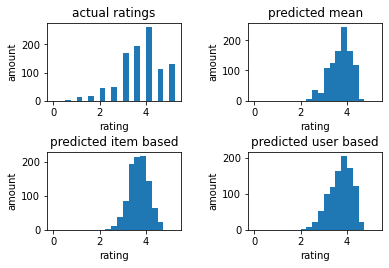

In [55]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.tight_layout(pad=3.0)

axes = [ax1, ax2, ax3, ax4]
data = [predicted_item_based['rating'], 
        predicted_item_mean['predicted rating'], 
        predicted_item_based['predicted rating'],
        predicted_user_based['predicted rating']]
titles = ["actual ratings", "predicted mean", "predicted item based", "predicted user based"]

for ax, d, title in zip(axes, data, titles):
    ax.hist(list(d), bins=list(np.arange(0,5.5,0.25)))
    ax.set_xlabel("rating")
    ax.set_ylabel("amount")
    ax.set_title(title)
 
print('     | actual | mean | item | user')
print('-----+--------+------+------+-----')
print(f'mean |   {data[0].mean():.2f} | {data[1].mean():.2f} | {data[2].mean():.2f} | {data[3].mean():.2f}')
print(f'std  |   {data[0].std():.2f} | {data[1].std():.2f} | {data[2].std():.2f} | {data[3].std():.2f}')

Je ziet dat de verdeling voorspelde ratings van alle drie de algoritmes (item based filtering, user based filtering en de mean baseline) er redelijk vergelijkbaar uitzien. Met een gemiddelde rond de 3.70 en standaarddeviatie van rond de 0.45. De daadwerkelijk rating daarentegen heeft een veel hogere standaarddeviatie (0.90). 

### Vraag 30

Probeer te beredeneren waarom de standaarddeviatie voor de voorspelde ratings lager is dan die van de daadwerlijke rating. Met ander woorden, waarom zijn zeer hoge en zeer lage voorspelde ratings relatief zeldzaam?

Zeer hoge en lage voorspelde ratings zijn relatief zeldzaam, omdat de voorspelde ratings gebaseerd zijn op gemiddeldes. Gemiddeldes zorgen ervoor dat de uitschieters verdwijnen uit de range van ratings, omdat de hoge uitschieters tegen de lage worden weggestreept. Verder is het ook zo dat gebruikers vaak juist de uitschieters toekennen, en maar weinig de waardes kiezen rond het gemiddelde.

Je hebt net gezien dat de *mse* van de baseline akelig dicht bij die van *user based collaborative filtering* komt. Het verschil is zelfs zo klein dat je je moet gaan afvragen of het nog wel significant is. Betekent dit dat user based filtering waardeloos is? 

Dat is moeilijk te zeggen, zelfs voor deze data. Een belangrijk vraag hierbij is: hoe betekenisvol is de maat *mse* zelf eigenlijk?

Om hier antwoord op te geven moeten we wat verder gaan kijken naar hoe het systeem uiteindelijk gebruikt wordt. Wat gebeurt er uiteindelijk in het systeem met de voorspelde rating? Wordt er een top 10 gegeven van items met de hoogste voorspelde rating? Worden er willekeurig 20 items aanbevolen waarvan de voorspelde rating hoger is dan 3.75? Kan de gebruiker invloed uitoefenen op de aanbevelingen? 

### Recommended items

We moeten dus wat concretere aannames doen over de werking van het recommender system: 
1. Voor elke gebruiker maken we een lijst met recommended items. Dat zijn films waarvoor de voorspelde rating hoger is dan of gelijk is aan een bepaalde drempelwaarde (bijvoorbeeld 3.75). 
2. En we maken een lijst met hidden items. Dit zijn films met een voorspelde rating die lager is dan de drempelwaarde, en die we dus niet willen aanbevelen. 
3. Vervolgens presenteren we de gebruiker met een lijst van $N$ willekeurige films uit de lijst van recommended items. (Deze aanname gaan we niet verder uitwerken in deze module, maar het is belangrijk om te weten dat alle recommended items een even grote kans hebben om aan de gebruiker getoond te worden.)

> Hiermee maken we van onze recommender system een classificatieprobleem: We hebben twee *classes*, recommended en hidden, en we willen van elk film/user paar weten in welke van de twee classes dit paar valt. Dit is een type probleem dat je bij machine learning vaak zal tegenkomen.

### Vraag 31 

Implementeer hieronder de functies `recommended()` en `hidden()`. Deze functies krijgen als input een DataFrame met de voorspelde ratings en een drempelwaarde (`treshold`). De output is een Dataframe met alle relevante combinaties van `userId` en `movieId`. 

In [56]:
def recommended(predictions, threshold):
    return predictions[predictions['predicted rating']>=threshold]
    

def hidden(predictions, threshold):
    return predictions[predictions['predicted rating']<threshold]
    
    
treshold_recommended = 3.75
recommended_items = recommended(predicted_item_based, treshold_recommended)
hidden_items = hidden(predicted_item_based, treshold_recommended)

print(f'Test items : {predicted_item_based.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())

Test items : 993
Recommended: 448
Hidden     : 545


,userId,movieId,rating,predicted rating
195,105,50,5.0,4.195964
207,105,750,4.0,4.217002
210,105,912,4.0,4.248759
217,105,1206,5.0,4.242905
218,105,1208,5.0,4.289307


,userId,movieId,rating,predicted rating
1,68,2,2.5,3.487983
3,68,47,4.0,3.457851
6,68,110,2.5,3.625071
14,68,344,2.5,3.457997
27,68,593,3.5,3.494299


In [57]:
answers.test_31(recommended, hidden, predicted_item_based, treshold_recommended)

Testing: success!


We weten nu voor elke gebruiker in de test set welke items aangeraden kunnen worden door het recommender systeem. Zijn die aanbevelingen terecht? Hiervoor kunnen we kijken naar de daadwerkelijke rating die gebruikers hebben gegeven. De aanname is dat als de gebruiker een hoge rating heeft gegeven dat de aanbevling dan terecht was. 

We noemen de items met een hoge aanbeveling *used* en items met een te lage aanbeveling *unused*. Ook hiervoor kunnen we weer een drempelwaarde voor gebruiken. Deze hoeft niet dezelfde te zijn als de drempelwaarde die recommended en hidden items van elkaar scheidt.

### Vraag 32

Implementeer hieronder de functies `used()` en `unused()`. Deze functies krijgen als input een DataFrame met de daadwerkelijke ratings en een drempelwaarde (`treshold`). De output is een Dataframe met alle relevante combinaties van `userId` en `movieId`. 

In [58]:
def used(predictions, threshold):
    return predictions[predictions['rating']>=threshold]
    

def unused(predictions, threshold):
    return predictions[predictions['rating']<threshold]
    
    
treshold_used = 4.0
used_items = used(predicted_item_based, treshold_used)
unused_items = unused(predicted_item_based, treshold_used)

print(f'Test items: {predicted_item_based.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(used_items.head())
display(unused_items.head())

Test items: 993
Used      : 503
Unused    : 490


,userId,movieId,rating,predicted rating
3,68,47,4.0,3.457851
28,68,595,4.5,3.607759
33,68,912,4.5,3.390595
46,68,1197,5.0,3.585229
63,68,1291,5.0,3.544625


,userId,movieId,rating,predicted rating
1,68,2,2.5,3.487983
6,68,110,2.5,3.625071
14,68,344,2.5,3.457997
27,68,593,3.5,3.494299
39,68,1073,0.5,3.283595


In [59]:
answers.test_32(used, unused, predicted_item_based, treshold_used)

Testing: success!


We hebben een hoop aannames moeten doen over de werking van het recommender system en de interpretatie van de resultaten. Maar nu hebben we iets meer gereedschappen om mee te evalueren.

We kunnen bij voorbeeld eerst eens kijken naar het aantal items dat ook daadwerkelijk terecht aabevolen is. Dat is namelijk het aantal items dat zowel in de lijst `recommended_items` als `used_items` zit. Dit noemen we de *true positives*. Gegeven de vier lijsten (recommended, hidden, used en unused), kunnen we de volgende waardes bepalen:

* **true positives**: het aantal items die zowel in de lijst van *recommended items* als *used items* voorkomen.
* **false positives**: het aantal items die zowel in de lijst van *recommended items* als *unused items* voorkomen.
* **true negatives**: het aantal items die zowel in de lijst van *hidden items* als *unused items* voorkomen.
* **false negatives**: het aantal items die zowel in de lijst van *hidden items* als *used items* voorkomen.

Deze vier waardes worden meestal weergegeven in de vorm van een [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

### Opdracht 33

Implementeer hieronder de functie 'confusion()' met als input de vier lijsten (*recommended*, *hidden*, *used* en *unused*) en als output een 2x2 DataFrame met de confusion matrix.

In [60]:
def confusion(recommended, hidden, used, unused):
    TP = len(recommended.index.intersection(used.index))
    FP = len(recommended.index.intersection(unused.index))
    FN = len(hidden.index.intersection(used.index))
    TN = len(hidden.index.intersection(unused.index))
    return pd.DataFrame([[TP,FP],[FN,TN]],columns=['used','unused'],index=['recommended','hidden'])
    

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,314,134
hidden,189,356


In [61]:
answers.test_33(confusion_matrix)

Testing: success!


### Precision

Een veelgebruikte maat voor evaluatie is **precision**. Precision is een maat voor de vraag: hoe vaak is een aanbevolen film ook terecht aanbevolen? 

Definitie:

$$
\textrm{precision} = \frac{\textrm{true positives}}{\textrm{#recommended items}} = \frac{\textrm{true positives}}{\textrm{true positives + false positives}}
$$

Dus, als alle films die worden aangeraden ook terecht zijn (i.e. $\textrm{false positives} = 0$), dan geldt:

$\textrm{precision} = 1$. 

Als geen van de films die worden aangeraden terecht zijn (i.e. $\textrm{true positives} = 0$) , dan geldt:

$\textrm{precision} = 0$. 

> Kijk voor meer informatie ook hier: https://en.wikipedia.org/wiki/Precision_and_recall

### Vraag 34

Implementeer de functie `precision()` hieronder, met als input de confusion matrix en als output de *precision*.

In [62]:
def precision(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['recommended','unused'])
    

precision_item_based = precision(confusion_matrix)

print(f'precision for item based prediction: {precision_item_based:.2f}')

precision for item based prediction: 0.70


In [63]:
answers.test_34(precision_item_based)

Testing: success!


### Recall

Precision zegt iets over hoe goed het algoritme werkt, maar zeker niet alles. Er zijn nog vele andere maten die relevant zijn voor de evaluatie van een algoritme. Een maat die veel in combinatie met precision wordt gebruikt is *recall*.

De centrale vraag bij **recall** is: hoe vaak worden items waarvan je zou willen dat ze aangeraden worden ook daadwerkelijk aangeraden door het algoritme? Met andere woorden als een gebruiker een film goed zou vinden, krijgt hij hem dan ook vaak aangeraden?

Definitie:

$$
\textrm{recall} = \frac{\textrm{true positives}}{\textrm{#used items}} = \frac{\textrm{true positives}}{\textrm{true positives + false negatives}}
$$

Dus, als we geen false negatives hebben (i.e. als alle films die de gebruike goed zou vinden ook daadwerkelijk worden aanbevolen), dan geldt: $\textrm{precision} = 1$.

### Vraag 35

Implementeer de functie `recall()` hieronder, met als input de confusion matrix en als output de *recall*.

In [64]:
def recall(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['hidden','used'])
    
    

recall_item_based = recall(confusion_matrix)

print(f'recall for item based prediction: {recall_item_based:.2f}')

recall for item based prediction: 0.62


In [65]:
answers.test_35(recall_item_based)

Testing: success!


### Vraag 36

Nu kunnen we eindelijk de verschillende aanpakken met elkaar vergelijken. Bereken hieronder de *precision* en *recall* voor:
* item base collaborative filtering
* user based collaborative filtering
* random baseline
* mean baseline.

In [66]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_item_based = recommended(predicted_item_based, treshold_recommended)
hidden_item_based = hidden(predicted_item_based, treshold_recommended)
used_item_based = used(predicted_item_based, treshold_used)
unused_item_based = unused(predicted_item_based, treshold_used)

recommended_item_mean = recommended(predicted_item_mean, treshold_recommended)
hidden_item_mean = hidden(predicted_item_mean, treshold_recommended)
used_item_mean = used(predicted_item_mean, treshold_used)
unused_item_mean = unused(predicted_item_mean, treshold_used)

recommended_random = recommended(predicted_random, treshold_recommended)
hidden_random = hidden(predicted_random, treshold_recommended)
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

recommended_user_based = recommended(predicted_user_based, treshold_recommended)
hidden_user_based = hidden(predicted_user_based, treshold_recommended)
used_user_based = used(predicted_user_based, treshold_used)
unused_user_based = unused(predicted_user_based, treshold_used)

confusion_item_based = confusion(recommended_item_based,hidden_item_based,used_item_based,unused_item_based)
confusion_item_mean = confusion(recommended_item_mean,hidden_item_mean,used_item_mean,unused_item_mean)
confusion_random = confusion(recommended_random,hidden_random,used_random,unused_random)
confusion_user_based = confusion(recommended_user_based,hidden_user_based,used_user_based,unused_user_based)

precision_item_based = precision(confusion_item_based)
recall_item_based = recall(confusion_item_based)

precision_item_mean = precision(confusion_item_mean)
recall_item_mean = recall(confusion_item_mean)

precision_random = precision(confusion_random)
recall_random = recall(confusion_random)

precision_user_based = precision(confusion_user_based)
recall_user_based = recall(confusion_user_based)

print('           | precision | recall')
print(f'item based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'user based |      {precision_user_based:.2f} |   {recall_user_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')
print(f'mean       |      {precision_item_mean:.2f} |   {recall_item_mean:.2f}')

           | precision | recall
item based |      0.70 |   0.62
user based |      0.66 |   0.69
random     |      0.55 |   0.34
mean       |      0.65 |   0.68


Bij recall zien we voor het eerst dat item based filtering het niet zo goed doet. Zowel user based filtering als bij mean per item is de recall-score hoger. Kennelijk gebeurt het bij item based filtering best vaak dat een film die de gebruiker best zou willen zien niet wordt aangeraden. Alleen zelfs dat zegt nog niet zoveel. Het is, bijvoorbeeld, waarschijnlijk (maar niet noodzakelijk) dat als we de `treshold_recommended` iets lager kiezen dat de recall dan omhoog gaat, maar de precision naar beneden.

### Vraag 37

Waarom is dat waarschijnlijk?

De recall is het percentage van used films dat recommended is. Met een lagere threshold worden er meer films aanbevolen, waardoor er een kans is dat daar ook used films in zitten, waardoor de recall groter kan worden omdat er een groter percentage recommended films zijn.

### Precision-recall curve

De performance van het algoritme is dus afhankelijk van de parameter `treshold_recommended`. En zoals je wel vaker zal zien in hebben we bij de keuze van die parameter te maken met een tradeoff tussen verschillende evaluatiematen. In dit geval is er sprake van ee tradeoff tussen *precision* en *recall*. In zo'n geval is het gebruikelijk om een precision-recall curve te plotten. Voer de onderstaande code uit om te zien hoe zo'n curve er uit kan zien.

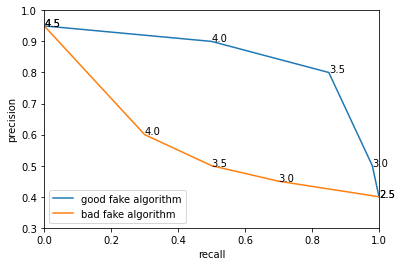

In [67]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

# good fake algorithm
precisons = [0.4, 0.5, 0.8, 0.9, 0.95]
recalls = [1.0, 0.98, 0.85, 0.5, 0]
plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, tresholds):
    plt.text(r, p, t)

# bad fake algorithm
precisons = [0.4, 0.45, 0.5, 0.6, 0.95]
recalls = [1.0, 0.7, 0.5, 0.3, 0]
plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, tresholds):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['good fake algorithm', 'bad fake algorithm'], loc = 'lower left')

In de plot hierboven zien we de waardes van zowel *precision* als *recall* voor verschillende waardes van de parameter `treshold_recommended` van twee denkbeeldige algoritmes. In een ideaal geval zouden we de *threshold* zo willen kiezen dat zowel *precision* als *recall* de waarde 1 hebben. Alleen voor geen van beide algoritmes is er zo'n waarde voor de * threshold*. We zien echter wel dat het goede algoritme (*good fake algorithm*) er een stuk dichter in de buurt komt. Deze plot geeft dus een stuk volledigere informatie over de werking van een algoritme dan een enkele waarde voor *precision* en *recall*.

Welke waarde voor de threshold het best is hang deels af van de toepassing. Is *precision* of *recall* een belangrijkere maat? Is het erger om onterecht films aan te raden? Of is het erger om films te negeren die de gebruiker wel graag had willen zien?

We kunnen er in dit geval wel iets over zeggen zonder in te gaan op de specifieke toepassing: Voor het goede algoritme is een een duidelijk cut-off te zien. Als je de *threshold* lager dan 3.5 kiest dan keldert de precision. het is dus in dit geval duidelijk een goed idee om de *threshold* in ieder geval boven de 3.5 te zetten.


### Vraag 38

Maak hieronder eenzelfde plot, maar nu met echte data. Plot de *precision-recall curves* voor:
* item base collaborative filtering
* user based collaborative filtering
* random baseline
* mean baseline.

Geef de `treshold_used` een vaste waarde van 3.75, en gebruik voor de `treshold_ recommended` waardes van 2.5 (inclusief) tot 5.0 (exclusief) met stappen van 0.5.

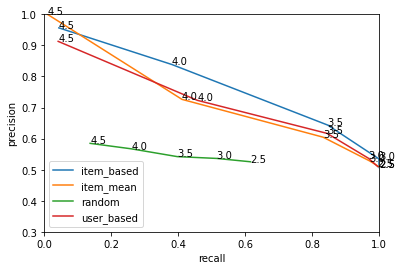

In [68]:
treshold_used = 3.75
treshold_recommended = [2.5,3.,3.5,4.,4.5]

recommended_item_based = [recommended(predicted_item_based, thresh) for thresh in treshold_recommended]
hidden_item_based = [hidden(predicted_item_based, thresh) for thresh in treshold_recommended]
used_item_based = used(predicted_item_based, treshold_used)
unused_item_based = unused(predicted_item_based, treshold_used)

recommended_item_mean = [recommended(predicted_item_mean, thresh) for thresh in treshold_recommended]
hidden_item_mean = [hidden(predicted_item_mean, thresh) for thresh in treshold_recommended]
used_item_mean = used(predicted_item_mean, treshold_used)
unused_item_mean = unused(predicted_item_mean, treshold_used)

recommended_random = [recommended(predicted_random, thresh) for thresh in treshold_recommended]
hidden_random = [hidden(predicted_random, thresh) for thresh in treshold_recommended]
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

recommended_user_based = [recommended(predicted_user_based, thresh) for thresh in treshold_recommended]
hidden_user_based = [hidden(predicted_user_based, thresh) for thresh in treshold_recommended]
used_user_based = used(predicted_user_based, treshold_used)
unused_user_based = unused(predicted_user_based, treshold_used)

confusion_item_based = [confusion(recommended_item_based[x],hidden_item_based[x],used_item_based,unused_item_based) for x in range(len(treshold_recommended))]
confusion_item_mean = [confusion(recommended_item_mean[x],hidden_item_mean[x],used_item_mean,unused_item_mean) for x in range(len(treshold_recommended))]
confusion_random = [confusion(recommended_random[x],hidden_random[x],used_random,unused_random) for x in range(len(treshold_recommended))]
confusion_user_based = [confusion(recommended_user_based[x],hidden_user_based[x],used_user_based,unused_user_based) for x in range(len(treshold_recommended))]

precision_item_based = [precision(confusion_item_based[x]) for x in range(len(treshold_recommended))]
recall_item_based = [recall(confusion_item_based[x]) for x in range(len(treshold_recommended))]

precision_item_mean = [precision(confusion_item_mean[x]) for x in range(len(treshold_recommended))]
recall_item_mean = [recall(confusion_item_mean[x]) for x in range(len(treshold_recommended))]

precision_random = [precision(confusion_random[x]) for x in range(len(treshold_recommended))]
recall_random = [recall(confusion_random[x]) for x in range(len(treshold_recommended))]

precision_user_based = [precision(confusion_user_based[x]) for x in range(len(treshold_recommended))]
recall_user_based = [recall(confusion_user_based[x]) for x in range(len(treshold_recommended))]

plt.plot(recall_item_based, precision_item_based)
for r, p, t in zip(recall_item_based, precision_item_based, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_item_mean, precision_item_mean)
for r, p, t in zip(recall_item_mean, precision_item_mean, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_random, precision_random)
for r, p, t in zip(recall_random, precision_random, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_user_based, precision_user_based)
for r, p, t in zip(recall_user_based, precision_user_based, treshold_recommended):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['item_based','item_mean','random', 'user_based'], loc = 'lower left')

De verschillen zijn niet zo enorm als bij het nepvoorbeeld, maar als het goed is, is er wel een algoritme dat het zichtbaar beter doet voor deze data.

### Vraag 39

Het zal je misschien opvallen dat de precision bij deze data nooit lager dan ongeveer 0.5 wordt. Waar zou dat door kunnen komen? 

Omdat de laagste threshold op 2.5 ligt, en dat is het midden van de ratings. Dus de helft zal er altijd boven liggen, waardoor de precision minimaal 0.5 is.

Bij deze algoritmes is de *threshold* een duidelijk parameter waarmee je de *precision* en *recall* kan beinvloeden. Maar, er zijn natuurlijk vaak nog meer dan genoeg andere parameters die van invloed kunnen zijn op deze waardes (bijvoorbeeld de waarde van `k` bij het selecteren van de *neighborhood*). Je zou in principe voor elke parameter zo'n curve kunnen maken bij het ontwerpen van een recommender system. Dat gaan we nu niet doen.

We gaan nog naar één ander interessant effect kijken: de data zelf. Dit soort algoritmes zijn op z'n best zo goed als de data die je ze voert. In dit geval hebben we gewerkt met een zeer dichte dataset. Voor ongeveer 80% van de mogelijke gebruiker-film paren is er een rating. Dat is héél veel meer dan je meestal zal tegenkomen als je een recommender system gaat bouwen. Deze data is een subset van een véél grote dataset waarvan de dichtheid lager dan 1% is.

Voer de code hieronder uit om een nieuwe dataset te laden. Deze set heeft een dichtheid van ongeveer 50%. Dat is nog steeds bij lange na niet zo laag als de oorspronkelijke dataset, maar hiermee kunnen we al gaan kijken of de dichtheid een effect heeft op het algoritm.

In [69]:
training_data = pd.read_pickle(f'./mini-movielens/ratings_t50_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t50_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t50_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t50_similarity_items.pkl')
predicted_item_based_50 = predict_ratings_item_based(similarity_items, utility_items, test_data)

### Vraag 40

Maak *precision-recall curve* voor alléén item based filtering met de bovenstaande dataset. Plot in dezelfde grafiek ook de item based filtering curve voor de oude dataset nog een keer.

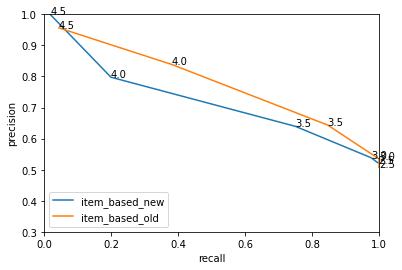

In [70]:
recommended_item_based_new = [recommended(predicted_item_based_50, thresh) for thresh in treshold_recommended]
hidden_item_based_new = [hidden(predicted_item_based_50, thresh) for thresh in treshold_recommended]
used_item_based_new = used(predicted_item_based_50, treshold_used)
unused_item_based_new = unused(predicted_item_based_50, treshold_used)

confusion_item_based_new = [confusion(recommended_item_based_new[x],hidden_item_based_new[x],used_item_based_new,unused_item_based_new) for x in range(len(treshold_recommended))]

precision_item_based_new = [precision(confusion_item_based_new[x]) for x in range(len(treshold_recommended))]
recall_item_based_new = [recall(confusion_item_based_new[x]) for x in range(len(treshold_recommended))]

plt.plot(recall_item_based_new, precision_item_based_new)
for r, p, t in zip(recall_item_based_new, precision_item_based_new, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_item_based, precision_item_based)
for r, p, t in zip(recall_item_based, precision_item_based, treshold_recommended):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['item_based_new','item_based_old'], loc = 'lower left')

### Vraag 41
Zou je een toepassing van een recommender system kunnen noemen waarvoor precision en recall géén relevante maten zijn?

Nee, want als dat zo zou zijn is er geen reden om een recommender system op te zetten. Het idee van zo'n systeem is altijd om goede recommendations te geven, en dat wordt gemeten met precision en recall. Dus op het moment dat die niet relevant zijn, is het recommender systeem ook niet meer relevant.

### Vraag 42
Je hebt voor de parameter *threshold_recommended* een precision-recall curve gemaakt, dus we hebben nu een redelijk beeld van het effect van die parameter op de kwaliteit van de voorspellingen. Welke parameters zou je nog meer kunnen(/moeten) onderzoeken?


De threshold van de used/unused zou een geteste parameter kunnen zijn. Verder de k bij de select_neighborhood zou ook nog gevarieerd kunnen worden. Waardes van k<10 zullen een grotere verschillen in de kwaliteit van de voorspellingen.

# Done

In het eerste deel heb je gezien hoe je *item based collaborative filtering* kan implementeren. Hiervoor heb je geleerd hoe je een *utility matrix* kan maken. Die utility matrix heb je gebruikt voor het maken van een *similarity matrix*. Hiervoor heb je verschillende similarity-maten uitgebprobeerd. Uiteindelijk heb je met de *cosine similarity* de rest van het algoritme uitgewerkt. Dit bestond uit het bepalen van een *neighborhood* en vervolgens het berekenen van een gewogen gemiddelde voor die neighborhood. In het tweede deel heb je gezien hoe je dezelfde technieken kan toepassen voor *user based* collaborative filtering. 

In het derde deel hebben we gekeken hoe we de geleerde algoritmes kunnen *evalueren*. Hierbij hebben we alleen gekeken naar *offline test* (dus alleen met de gegeven historische data). Om dit te doen, moeten we een hoop aannames doen over gebruikersgedrag. De enige manier om deze aannames te toetsen zou met online testen. Wij kunnen dat niet doen binnen deze cursus, maar dit is wel wat bedrijven zoals Facebook continu doen. 

Er valt nog heel veel meer te zeggen over het onderwerp van evaluatie. Dit is een onderwerp wat ook buiten het domein van recommender systems van belang is. Onder andere veel machine learning algoritmes worden op vergelijkbare manier getoetst. Voor meer informatie:

* [Wikipedia, Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* [Wikipedia, Recommender systems](https://en.wikipedia.org/wiki/Recommender_system#Performance_measures)
* [G. Shani, A. Gunawardana, *Evaluating recommendation systems*](https://www.researchgate.net/publication/226264572_Evaluating_Recommendation_Systems) (gratis te downloaden vanaf het UvA netwerk).
* [M. Ge, C Delgado-Battenfeld, Dietmar Jannach, *Beyond Accuracy: Evaluating Recommender Systems by Coverage and Serendipity*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.8494&rep=rep1&type=pdf)


### Volgende module

Bij de laatste opgave zagen we dat de dichtheid van de dataset een effect heeft op de werking van collaborative filtering. Als de dichtheid lager wordt, werkt collaborative filtering minder goed. In de volgende module gaan we zien hoe we content based filtering kunnen gebruiken om dit probleem op te lossen.

## Extra conceptvragen 
Deze vragen hoef je niet in te leveren, maar zijn handig om te oefenen voor het tentamen.

### Conceptvraag 1
We hebben een hoop aannames gedaan bij het testen van de bovenstaande algoritmes. Bijvoorbeeld, een daadwerkelijk rating hoger dan 4.0 betekent dat een film terecht is aangeraden.

- a. Noem ten minste nog twee aannames die we hebben gedaan bij het evalueren van de *collaboratve filtering* algoritmes.
- b. Doe een suggestie voor een online evaluatie of gebruikersstudie waarmee we kunnen testen of deze aannames terecht zijn.

### Conceptvraag 2:
De maten die we hierboven hebben behandeld worden heel veel gebruikt, maar zijn zeker niet de enige mogelijke maten. Er zijn nog talloze vragen die we kunnen stellen over het systeem waar de huidige maten geen antwoord op geven. Bijvoorbeeld:
- Hoe groot de kans is dat gebruikers nieuwe filmgenres ontdekken? 
- Voor een nieuwsmediasite: Hoe groot is de kans dat gebruikers in een filterbubbel terechtkomen?
- Hoe groot is de kans dat een minder populair item wordt aanbevolen?
- Hoe groot is de diversiteit van aanbevolen films.

Kan je zelf een nuttige maat verzinnen die hier nog niet is behandeld? Wat is de definitie? Op welke vraag geeft de maat een antwoord? Waarom is dat een nuttige vraag?
